In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import stats
import pickle
import subprocess
import pandas as pd
import mdtraj as mdt

import os
import re
import copy
import datetime
import time

%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.patches import Rectangle

## Load metadynamics weights

Here we load the metadynamics bias deposited during the simulation:

In [2]:
metadb=np.loadtxt("./bias_colvar_180ns_full", skiprows=1, unpack=True)
metadb.shape

(12, 36001)

and we use it to compute the frame-by-frame weights:

In [3]:
weights=np.exp((metadb[-1]-np.max(metadb[-1]))/2.5) # avoid numeric overflow
weights=weights/np.sum(weights) # normalize

## Load reference experimental data

Here we load the reference experimental data as computed in "Welty et al., RNA, 2018, 24(12), 1828–1838".

In [4]:
gac_k=np.loadtxt('./gac_kcl.dat')
gac_mg=np.loadtxt('./gac_kcl_mgcl2.dat')

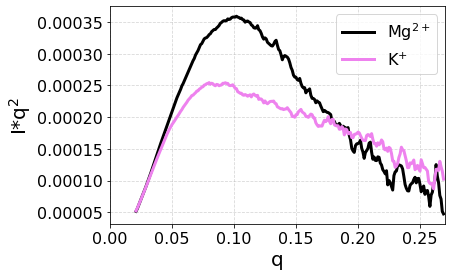

In [5]:
plt.plot(gac_mg[:,0],gac_mg[:,1]*gac_mg[:,0]**2,lw=3,color='black',label='Mg$^{2+}$')
plt.plot(gac_k[:,0],gac_k[:,1]*gac_k[:,0]**2,lw=3,color='violet',label='K$^{+}$')

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('q',fontsize=20)
plt.ylabel('I*q$^2$',fontsize=20)
plt.xlim(0,0.27)
plt.grid(ls='--',alpha=0.5)

plt.show()
#plt.savefig('SI_FIG_exp_spectra.png', format='png', dpi=300, bbox_inches='tight')

In [5]:
x_mg = gac_mg[:,0]
y_mg = gac_mg[:,1] #*gac_mg[:,0]**2

x_k = gac_k[:,0]
y_k = gac_k[:,1] #*gac_k[:,0]**2

## Load spectra

In this section we compute the SAXS spectra computed with PLUMED, Capriqorn and CRYSOL:

In [10]:
# # PLUMED SPECTRA

# path="/scratch/mbernett/gtpase/production_hrex_all_16_2d_redo_SAXSplumed_MARTINI_wallonratio/check_spectra/"
# allI=np.loadtxt(path+"colvar_all_all-martini_180ns", skiprows=1)
# #allI=allI[:-1,3:]
# allI=allI[:,3:]

In [175]:
# fname = "allI_plum_36001.dat"
# pickle.dump(allI,open(fname, "wb"))

In [7]:
allI = pickle.load(open("./allI_plum_36001.dat", "rb"))
allI = np.array(allI)

In [8]:
observables=np.array(allI) #*q**2)
observables.shape

(36001, 51)

In [ ]:
# HUMMER SPECTRA

# path="/scratch/mbernett/gtpase/production_hrex_all_16_2d_redo_SAXSplumed_MARTINI_wallonratio/\
# spectra_Hummer_hrex_162d_SAXSplumed_MARTINI_wallonratio/redone_with_average_dens/"

# blocks=18
# allI_Hum=[]
# for i in range(blocks):
#     if i < 17: # 1000 frames for each block, 1001 for the last block: 36001
#         for j in range(1,2001):
#             allI_i=np.loadtxt(path+"spectra_block%s/" % (i+1)+"dI_frame%s.dat" % (j+(i*2000)))[:,1]
#             allI_Hum.append(allI_i)
#     else:
#         for j in range(1,2002):
#             allI_i=np.loadtxt(path+"spectra_block%s/" % (i+1)+"dI_frame%s.dat" % (j+(i*2000)))[:,1]
#             allI_Hum.append(allI_i)
            
# allI_Hum=np.array(allI_Hum)

In [24]:
# fname = "allI_Hum_wallonratio_180ns_36001_redone.dat"
# pickle.dump(allI_Hum,open(fname, "wb"))

In [6]:
allI_Hum = pickle.load(open("./allI_Hum_wallonratio_180ns_36001_redone.dat", "rb"))
allI_Hum = np.array(allI_Hum)

In [7]:
observables_Hum=np.array(allI_Hum) #*q**2)

In [470]:
# # CRYSOL SPECTRA

# # CRYSOL
# path='/scratch/mbernett/gtpase/production_hrex_all_16_2d_redo_SAXSplumed_MARTINI_wallonratio/\
# crysol_spectra_RNAonly/'

# allI_crys=[] # check effect of structure extension on the computed Rg*
# for j in range(0,36001):
#     allI_crys.append(np.loadtxt(path+"frame_0%05d00.int" % j,skiprows=1)[:,1])

In [471]:
# fname = "allI_crys_wallonratio_180ns_36001.dat"
# pickle.dump(allI_crys,open(fname, "wb"))

In [11]:
allI_crys = pickle.load(open("./allI_crys_wallonratio_180ns_36001.dat", "rb"))
allI_crys = np.array(allI_crys)

In [12]:
observables_crys=np.array(allI_crys)

### Compute Rg* for the the experimental spectra

Using the Guinier fit procedure, we estimate the Rg* from the reference experimental spectra that we loaded:

In [13]:
def linefitline(x):
    return intercept + slope * x # y = b + m*x

In [14]:
# same range for q as in SI of Welty 2018
gac_mg[:41,0]

array([0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,
       0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038,
       0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047,
       0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056,
       0.057, 0.058, 0.059, 0.06 , 0.061])

In [15]:
# Guinnier experimental for Mg
slope, intercept, r_value, p_value, std_err = stats.linregress(
    gac_mg[:41,0]**2,
    np.log(gac_mg[:41,1]/gac_mg[0,1]))

In [16]:
fitted_line = linefitline(gac_mg[:41,0]**2)

In [17]:
print('Guinier fit Rg:')
np.sqrt(-3*slope)

Guinier fit Rg:


21.350359854129284

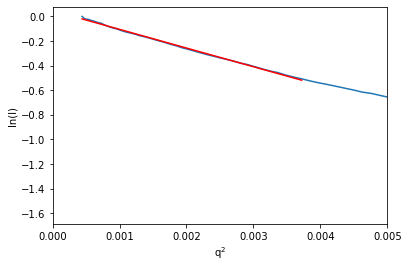

In [18]:
plt.plot(gac_mg[:100,0]**2,np.log(gac_mg[:100,1]/gac_mg[0,1]))
plt.plot(gac_mg[:41,0]**2,fitted_line, c='red')

plt.xlabel('q$^2$')
plt.ylabel('ln(I)')

plt.xlim(0,0.005)

plt.show()

In [19]:
# Guinnier experimental for K
slope, intercept, r_value, p_value, std_err = stats.linregress(
    gac_k[:41,0]**2,
    np.log(gac_k[:41,1]/gac_k[0,1]))

In [20]:
fitted_line = linefitline(gac_k[:41,0]**2)

In [21]:
print('Guinier fit Rg:')
np.sqrt(-3*slope)

Guinier fit Rg:


25.168689598762615

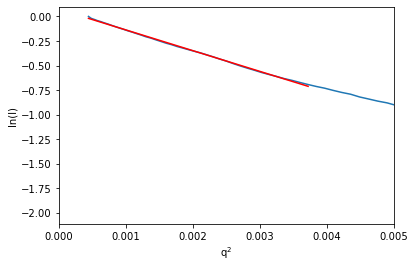

In [22]:
plt.plot(gac_k[:100,0]**2,np.log(gac_k[:100,1]/gac_k[0,1]))
plt.plot(gac_k[:41,0]**2,fitted_line, c='red')

plt.xlabel('q$^2$')
plt.ylabel('ln(I)')

plt.xlim(0,0.005)

plt.show()

## Reweighting through maxent enforcing 4 points: Capriqorn spectra

Here we perform the reweighting taking advantage of the maximumm entropy principle. We enforce 4 points of the SAXS spectrum that included the Guinier fit region and the peak and shoulder points of the spectrum in the Kratky form.

In [8]:
# the q range used for all the spectra below
q = np.linspace(0, 0.5, num=51, endpoint=True,) # genero l'asse x del grafico

In [24]:
names=['metad','MG','K']
e_series=np.array([[np.average(observables_Hum,axis=0,weights=weights)[3],
                    np.average(observables_Hum,axis=0,weights=weights)[5],
                   np.average(observables_Hum,axis=0,weights=weights)[10],
                    np.average(observables_Hum,axis=0,weights=weights)[20]],
                   [y_mg[9],y_mg[29],np.average(y_mg[69:90]),np.average(y_mg[169:190])],
                   [y_k[9],y_k[29],np.average(y_k[69:90]),np.average(y_k[169:190])]])

In [25]:
q[2:7],x_mg[:41]

(array([0.02, 0.03, 0.04, 0.05, 0.06]),
 array([0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,
        0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038,
        0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047,
        0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056,
        0.057, 0.058, 0.059, 0.06 , 0.061]))

In [26]:
q[[3,5,10,20]],x_mg[[9,29,79,179]]

(array([0.03, 0.05, 0.1 , 0.2 ]), array([0.03, 0.05, 0.1 , 0.2 ]))

In [9]:
def weights_prop(l,metadb,observables,e):
    l = np.array(l)
    weight_all = metadb / 2.5 # metadb[-1] / 2.5
    obs_prop=observables - np.outer(np.sum(observables,axis=1),e)/np.sum(e)
    #print(observables[0],obs_prop[0])
    
    weight_all -= np.dot(obs_prop,l) # calcolo esponente della formula del maxent
    shift_all = np.max(weight_all) # da sottrarre per evitare il solito problema dell'overflow
    weight_all = np.exp(weight_all - shift_all) # uso l'esponente calcolato sopra per ottenere i pesi
    
    return weight_all/ np.sum(weight_all)

def Gamma_prop(l,metadb,observables,e,sigma=0.0):
    l = np.array(l)
    weight_all = metadb / 2.5 # metadb[-1] / 2.5
    obs_prop=observables - np.outer(np.sum(observables,axis=1),e)/np.sum(e)
    #print(observables[0],obs_prop[0])
    
    weight_all -= np.dot(obs_prop,l) # calcolo esponente della formula del maxent
    shift_all = np.max(weight_all) # da sottrarre per evitare il solito problema dell'overflow
    weight_all = np.exp(weight_all - shift_all) # uso l'esponente calcolato sopra per ottenere i pesi
    
    weight_mt = metadb / 2.5 # metadb[-1] / 2.5
    shift_mt = np.max(weight_mt)
    weight_mt = np.exp(weight_mt - shift_mt)
    
    f = np.log(np.sum(weight_all) / np.sum(weight_mt)) + shift_all - shift_mt
    der = - np.dot(weight_all,obs_prop) / np.sum(weight_all) # derivative with respect to l
    
    #sigma=1e-10 # UNITS OF THE OBSERVABLES. Set to 1e-10 to set it to zero.
    reg=(sigma)**2 #(sigma*e)**2 
    f+=0.5*np.sum(reg*l**2)
    der+=reg*l
    return(f,der)

In [29]:
dict_maxent={}

In [30]:
kish_series_Hum = []
weights_me_save_Hum = []

factor=1/1000 # div observables for a big number for numeric reas (we care about ratios, not a problem doing so)
for i in range(len(names)):
    res_prop_i = minimize(Gamma_prop, np.array((0.0,0.0,0.0,0.0)), method='BFGS',tol=1e-10,jac=True,
               args=(metadb[-1],factor*observables_Hum[:,[3,5,10,20]],e_series[i],0))
    w_prop_i = weights_prop(res_prop_i.x,metadb[-1],factor*observables_Hum[:,[3,5,10,20]],e_series[i])
    kish_i = 1 / np.sum(w_prop_i**2)
    ###
    dict_maxent[names[i],'hummer_4p','metad','singles','e_ratios']=e_series[i,2]/e_series[i,3]
    dict_maxent[names[i],'hummer_4p','metad','singles','kish_sizes']=kish_i
    dict_maxent[names[i],'hummer_4p','metad','singles','weights_me']=w_prop_i
    dict_maxent[names[i],'hummer_4p','metad','singles','lagr_mult']=res_prop_i.x   

In [31]:
print('Kish sizes:')
print('metad',dict_maxent['metad','hummer_4p','metad','singles','kish_sizes'])
print('MG',dict_maxent['MG','hummer_4p','metad','singles','kish_sizes'])
print('K',dict_maxent['K','hummer_4p','metad','singles','kish_sizes'])

Kish sizes:
metad 5690.937864373405
MG 15.919885518099893
K 2.917453974743362


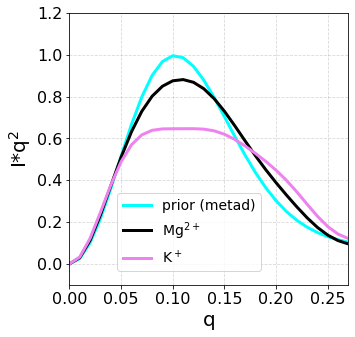

In [301]:
plt.figure(figsize=(5,5))
# plt.plot(q,np.average(observables_Hum,axis=0,weights=dict_maxent['hummer','metad','singles','weights_me'][2]),
#        lw=3,color='black')    
   
# plt.plot(q,np.average(observables_Hum,axis=0,weights=dict_maxent['hummer','metad','singles','weights_me'][3]),
#        lw=3,color='black')

plt.plot(q,np.average(observables_Hum,axis=0,
                      weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,color='cyan',label='prior (metad)')
plt.plot(q,np.average(observables_Hum,axis=0,
                      weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,color='black',label='Mg$^{2+}$')
plt.plot(q,np.average(observables_Hum,axis=0,
                      weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,color='violet',label='K$^+$')
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('q',fontsize=20)
plt.ylabel('I*q$^2$',fontsize=20)
plt.xlim(0,0.27)
plt.grid(ls='--',alpha=0.5)

plt.ylim(-0.1,1.2)
plt.legend(fontsize=14,loc=(0.17,0.05))
plt.show()
#plt.savefig('FIGSI_all_reweighted_with_crystal.png', format='png', dpi=300, bbox_inches='tight')

In [47]:
# error (bootstrap) on the spectra
names=['metad','MG','K']
#err_spectr={}
#err_rgs={}
err_reweighted={}
for i in range(len(names)):
    # error
    nb=10 # N blocks, applies to both weights and spectra arrays
    npt=51 # N points per observable: saxs spectra have 51 q points in my case
    weights=copy.deepcopy(dict_maxent[names[i],'hummer_4p','metad','singles','weights_me'][:-1])
    weights=weights.reshape((nb,-1)) # blocchi dei pesi
    spectra=copy.deepcopy(observables_Hum[:-1]) # blocchi degli spettri
    spectra=spectra.reshape((nb,-1,npt))
    obs_j=[]
    rgs_j=[]
    for b in range(400):
        shuffle=np.random.choice(nb,size=nb) # re-sample by shuffling blocks
        resamp_w=weights[shuffle][:,:].reshape((-1)) # resampled weights
        resamp_s= spectra[shuffle][:,:,:].reshape((-1,npt)) # resampled spectra
        rew_s=(np.average(resamp_s,axis=0,weights=resamp_w)) # reweighted spectrum
        # 
        obs_j.append(rew_s[[10,15,20]]*q[[10,15,20]]**2)
        #
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            q[2:7]**2,
            np.log(rew_s[2:7]/rew_s[0]))
        rgs_j.append(np.sqrt(-3*slope))
    obs_j=np.array(obs_j)
    rgs_j=np.array(rgs_j)
    # rgs
    slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(observables_Hum,axis=0,
                      weights=dict_maxent[names[i],'hummer_4p','metad','singles','weights_me'])[2:7]))
    # add to dictionary
    err_reweighted[names[i],'spectr']=np.array([np.std(obs_j[:,0]),np.std(obs_j[:,1]),np.std(obs_j[:,2])])
    err_reweighted[names[i],'rgs_err']=np.std(rgs_j)
    err_reweighted[names[i],'rgs']=np.sqrt(-3*slope)

In [48]:
err_reweighted['MG','rgs'],err_reweighted['MG','rgs_err']

(21.121790779721273, 0.4872639114406384)

In [49]:
err_reweighted['K','rgs'],err_reweighted['K','rgs_err']

(24.923203521146487, 1.0569160067911065)

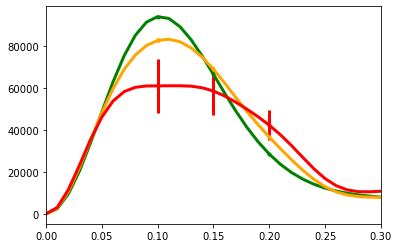

In [50]:
colors=['green','orange','red']
for i in range(len(names)):
    plt.plot(q,
             np.average(observables_Hum,axis=0,
                      weights=dict_maxent[names[i],'hummer_4p','metad','singles','weights_me'])*q**2,
             lw=3,color=colors[i])
    plt.errorbar(q[[10,15,20]],
                (np.average(observables_Hum,axis=0,
                          weights=dict_maxent[names[i],'hummer_4p','metad','singles','weights_me'])*q**2)[[10,15,20]],
                 yerr=err_reweighted[names[i],'spectr'],fmt='.',lw=3,color=colors[i])
    
plt.xlim(0,0.3)
plt.show()

In [51]:
# Lagrange multipliers
dict_maxent['MG','hummer_4p','metad','singles','lagr_mult'],\
dict_maxent['K','hummer_4p','metad','singles','lagr_mult']

(array([ 0.00748749,  0.01209229,  0.0120473 , -0.03162708]),
 array([ 0.00387421,  0.02486891,  0.00930744, -0.03805056]))

### check peak/shoulder ratios

Here we compare the peak/shoulder ratio in references and compare them with the ones obtained from the reweighted ensembles for Mg2+ and K+.

In [57]:
(np.average(observables_Hum,axis=0,weights=weights)[10]*q[10]**2)/\
(np.average(observables_Hum,axis=0,weights=weights)[20]*q[20]**2)

3.2985023257963553

In [58]:
weights.shape

(36001,)

In [59]:
print('ratio metad')
(np.average(observables_Hum,axis=0,weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables_Hum,axis=0,weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])*q**2)[20]

ratio metad


3.298502325796354

In [60]:
np.average((y_mg*x_mg**2)[69:90])/np.average((y_mg*x_mg**2)[169:190])

2.245962769409604

In [61]:
print('ratio MG')
(np.average(observables_Hum,axis=0,weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables_Hum,axis=0,weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2)[20]

ratio MG


2.256824998607609

In [62]:
np.average((y_k*x_mg**2)[69:90])/np.average((y_k*x_mg**2)[169:190])

1.4285539509989715

In [63]:
print('ratio K')
(np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2)[20]

ratio K


1.4437016081768352

### Weights

Here we show the weights obtained for the reweighted ensembles through the reweighting procedure.

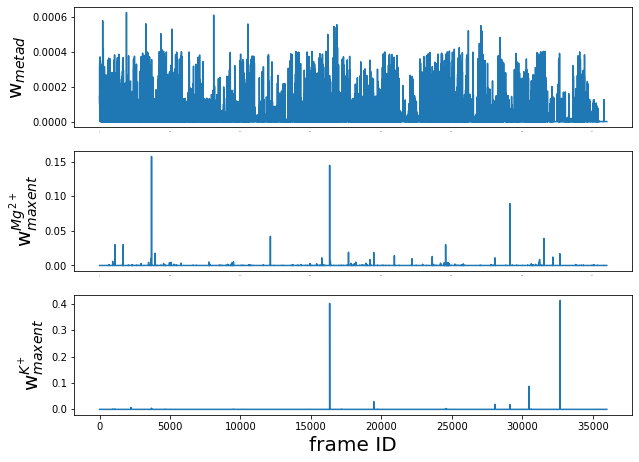

In [64]:
plt.figure(figsize=(10, 7.5))
plt.subplot(311)
plt.plot(weights)
plt.ylabel('w$_{metad}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)

plt.subplot(312)
plt.plot(dict_maxent['MG','hummer_4p','metad','singles','weights_me'])
plt.ylabel('w$_{maxent}^{Mg^{2+}}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)

plt.subplot(313)
plt.plot(dict_maxent['K','hummer_4p','metad','singles','weights_me'])
plt.ylabel('w$_{maxent}^{K^{+}}$',fontsize=20)
plt.xlabel('frame ID',fontsize=20)

plt.show()
#plt.savefig('SI_FIG_weights_hummer_spectra_redone.png', format='png', dpi=300, bbox_inches='tight')

### Guinier fit on the reweighted spectra

Here we estimate the Rg* on the reweighted SAXS spectra through the Guinier fit procedure.

In [65]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])[2:7]))

In [66]:
fitted_line = linefitline(q[2:7]**2)

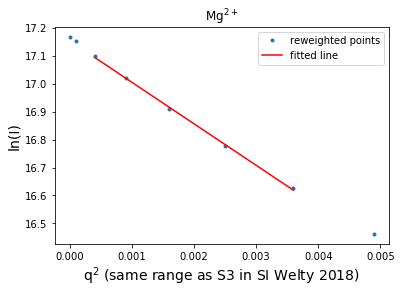

In [67]:
plt.plot(q[:8]**2,np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('Mg$^{2+}$')
plt.legend()
plt.show()

In [68]:
print('Guinier fit Rg* (exp. is 21.35):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 21.35):


21.121790779721273

In [69]:
print('weighted Rgcoord:')
np.average(metadb[1]*10,weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])

weighted Rgcoord:


16.32910845422635

In [70]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])[2:7]))

In [71]:
fitted_line = linefitline(q[2:7]**2)

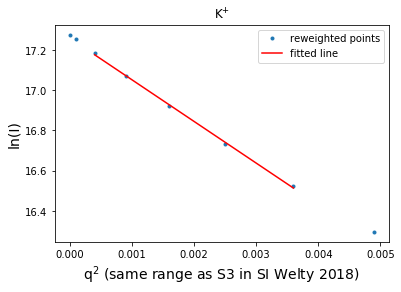

In [72]:
plt.plot(q[:8]**2,np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('K$^{+}$')
plt.legend()
plt.show()

In [73]:
print('Guinier fit Rg* (exp. is 25.17):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 25.17):


24.923203521146487

In [74]:
print('weighted Rgcoord:')
np.average(metadb[1]*10,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])

weighted Rgcoord:


18.88242724878345

## Figure 5

### Guinier fit of all the metad spectra

In [75]:
guin_pl_sp=[] # frame by frame with scipy
for i in range(len(allI)):
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(allI[i][2:7]/allI[i][0]))
    guin_pl_sp.append(np.sqrt(-3*slope))
    
guin_pl_sp=np.array(guin_pl_sp) 
guin_pl_sp.shape


(36001,)

In [80]:
allI_Hum.shape

(2000, 51)

In [83]:
guin_hum_sp=[] # frame by frame with scipy
for i in range(len(allI)):
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(allI_Hum[i][2:7]/allI_Hum[i][0]))
    guin_hum_sp.append(np.sqrt(-3*slope))
    
guin_hum_sp=np.array(guin_hum_sp) 
guin_hum_sp.shape


/u/m/mbernett/my_progs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


(36001,)

In [84]:
punti_mg=[guin_pl_sp,
          guin_pl_sp,
          guin_hum_sp,
          guin_hum_sp]
pesi_mg=[weights,
         dict_maxent['MG','hummer_4p','metad','singles','weights_me'],
         weights,
         dict_maxent['MG','hummer_4p','metad','singles','weights_me']]

same_min=np.nanmin(guin_hum_sp)
same_max=np.nanmax(guin_hum_sp)
X_plot=np.linspace(same_min,same_max,1000)
kdes_mg=[]
for i in range(len(punti_mg)):
    X=punti_mg[i][~np.isnan(punti_mg[i])]
    X_weights=pesi_mg[i][~np.isnan(punti_mg[i])]
    gkde=stats.gaussian_kde(X,weights=X_weights)
    kdepdf_i = gkde.evaluate(X_plot)
    kdes_mg.append(kdepdf_i)
kdes_mg=np.array(kdes_mg)

In [85]:
punti_k=[guin_pl_sp,
          guin_pl_sp,
          guin_hum_sp,
          guin_hum_sp]
pesi_k=[weights,
         dict_maxent['K','hummer_4p','metad','singles','weights_me'],
         weights,
         dict_maxent['K','hummer_4p','metad','singles','weights_me']]


same_min=np.nanmin(guin_hum_sp)
same_max=np.nanmax(guin_hum_sp)
X_plot=np.linspace(same_min,same_max,1000)
kdes_k=[]
for i in range(len(punti_k)):
    X=punti_k[i][~np.isnan(punti_k[i])]
    X_weights=pesi_k[i][~np.isnan(punti_k[i])]
    gkde=stats.gaussian_kde(X,weights=X_weights)
    kdepdf_i = gkde.evaluate(X_plot)
    kdes_k.append(kdepdf_i)
kdes_k=np.array(kdes_k)

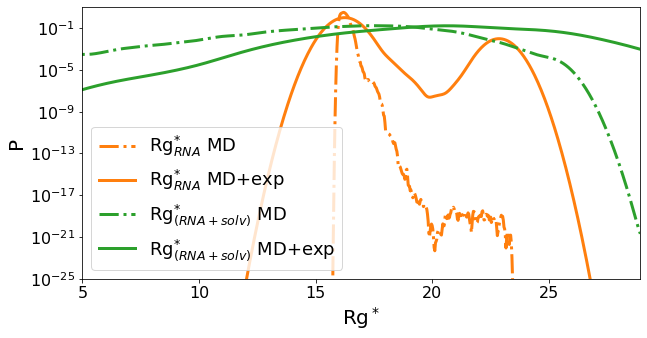

In [793]:
plt.figure(figsize=(10, 5)) # 10,7

colors=['C1','C1',
        'C2','C2']
linest=['-.','-',
        '-.','-']
lweights=[2,2,2,2,2,2]
lweights=[3,3,3,3,3,3]

labels=['Rg$^{*}_{RNA}$ MD',
        'Rg$^{*}_{RNA}$ MD+exp',
        'Rg$^{*}_{(RNA+solv)}$ MD',
        'Rg$^{*}_{(RNA+solv)}$ MD+exp']

kt=2.5/4.184 # in kcal/mol
for i in range(len(punti_mg)):
    plt.plot(X_plot,kdes_mg[i],label=labels[i],c=colors[i],lw=lweights[i],ls=linest[i])

plt.xlabel('Rg$^*$',fontsize=20)
plt.ylabel('P',fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(5,np.nanmax(guin_hum_sp))
plt.ylim(1e-25,1e1) # plt.ylim(1e-25,1)
    
plt.yscale("log")

plt.legend(fontsize=18)#,loc=(0.008,0.32)) # 14
    
plt.show()
#plt.savefig('FIG5_plot_mg_plumed_redone.png', format='png', dpi=300, bbox_inches='tight')

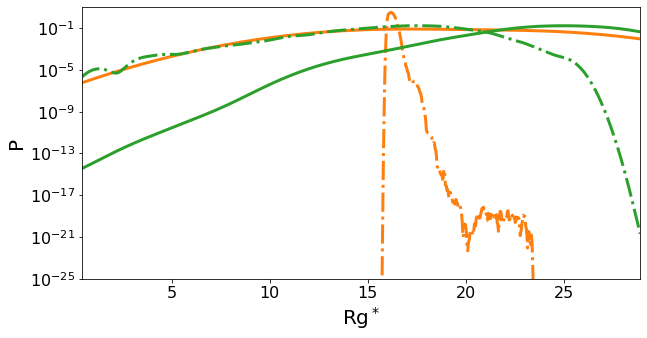

In [782]:
plt.figure(figsize=(10, 5)) # 10,7

colors=['C1','C1',
        'C2','C2']
linest=['-.','-',
        '-.','-',
        '-.','-']
lweights=[2,2,2,2,2,2]
lweights=[3,3,3,3,3,3]

labels=['Rg$^{*}_{RNA}$ MD',
        'Rg$^{*}_{RNA}$ MD+exp',
        'Rg$^{*}_{(RNA+solv)}$ MD',
        'Rg$^{*}_{(RNA+solv)}$ MD+exp']

kt=2.5/4.184 # in kcal/mol
for i in range(len(punti_k)):
    plt.plot(X_plot,kdes_k[i],label=labels[i],c=colors[i],lw=lweights[i],ls=linest[i])

plt.xlabel('Rg$^*$',fontsize=20)
plt.ylabel('P',fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(np.nanmin(guin_hum_sp),np.nanmax(guin_hum_sp)) # plt.xlim(1,30)
plt.ylim(1e-25,1e1) # plt.ylim(1e-25,1)
    
plt.yscale('log')
    
#plt.show()
plt.savefig('FIG5_plot_k_plumed_redone.png', format='png', dpi=300, bbox_inches='tight')

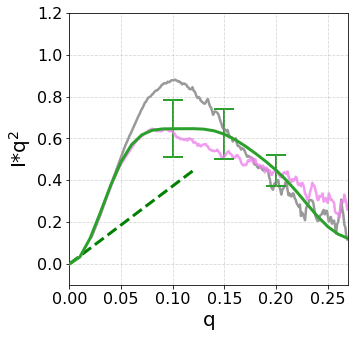

In [772]:
plt.figure(figsize=(5, 5)) 

to_normalize=np.max(np.average(
    observables_Hum,axis=0,
    weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2)
#to_normalize=1

lw=8
alphas=[1,0.4,0.4,0.8]
zorders=[10,0,0,0]

# plt.plot(q,
#          np.average(observables_Hum,axis=0,weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2/
#          np.max(avg_hum*q**2),
#        lw=3,label='hum MD+exp',zorder=zorders[2],c='C2')
plt.plot(q,
        np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2/
        np.max(avg_hum*q**2),
      lw=3,label='hum MD+exp',zorder=10,c='C2')

plt.plot(gac_mg[:,0],
        (gac_mg[:,1]*gac_mg[:,0]**2)/np.max((gac_mg[:,1]*gac_mg[:,0]**2))*
         np.max(np.average(observables_Hum,axis=0,weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2)/
         np.max(avg_hum*q**2),lw=2.5,label='exp',color='grey',alpha=alphas[3],zorder=zorders[3])
plt.plot(gac_k[:,0],
        (gac_k[:,1]*gac_k[:,0]**2)/np.max((gac_k[:,1]*gac_k[:,0]**2))*
         np.max(np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2)/
         np.max(avg_hum*q**2),lw=2.5,label='exp',color='violet',alpha=alphas[3],zorder=zorders[3])

# Line Fits:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[:2],
    #(np.average(observables_Hum,axis=0,weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2)[:2]/
    (np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2)[:2]/
    to_normalize)
#fitted_line_mg_maxent = linefitline(np.linspace(0,0.12,13))
fitted_line_k_maxent = linefitline(np.linspace(0,0.12,13))
#plt.plot(np.linspace(0,0.12,13),fitted_line_mg_maxent,'--',lw=3,c='green')
plt.plot(np.linspace(0,0.12,13),fitted_line_k_maxent,'--',lw=3,c='green')

# plt.errorbar(q[[10,15,20]],
#          (np.average(observables_Hum,axis=0,weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2)[[10,15,20]]/
#          np.max(avg_hum[[10,15,20]]*q[[10,15,20]]**2),
#              yerr=err_reweighted['MG','spectr']/np.max(avg_hum[[10,15,20]]*q[[10,15,20]]**2),
#              fmt='.',lw=3,zorder=zorders[2],c='C2',capsize=10,capthick=2,markersize=5)

plt.errorbar(q[[10,15,20]],
         (np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2)[[10,15,20]]/
         np.max(avg_hum[[10,15,20]]*q[[10,15,20]]**2),
             yerr=err_reweighted['K','spectr']/np.max(avg_hum[[10,15,20]]*q[[10,15,20]]**2),
             fmt='.',lw=2,zorder=zorders[2],c='C2',capsize=10,capthick=2,markersize=2)

#plt.tick_params(axis='both', labelsize=0, length = 0) # fontsize and tick size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('q',fontsize=20)
plt.ylabel('I*q$^2$',fontsize=20)
plt.xlim(0,0.27)
plt.grid(ls='--',alpha=0.5)

plt.ylim(-0.1,1.2)
#plt.legend()
#plt.show()
plt.savefig('FIG5_spectrum_k_redone.png', format='png', dpi=300, bbox_inches='tight')

## Figure 1

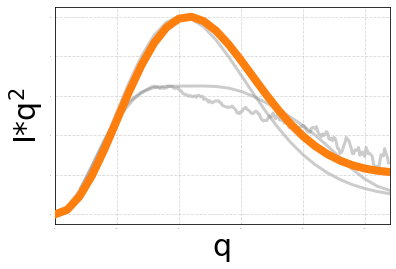

In [92]:
to_normalize=np.max(np.average(observables_Hum,axis=0,weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])*q**2)

lw=8
# 0
colors=['C1','grey','grey','grey'] # orange
alphas=[1,0.4,0.4,0.4]
zorders=[10,0,0,0]
lws=[8,3,3,3]
# # # 1
# colors=['grey','deepskyblue','grey','grey']
# alphas=[0.4,1,0.4,0.4]
# zorders=[0,10,0,0]
# lws=[3,8,3,3]
# # 2
# colors=['grey','grey','C2','grey']
# alphas=[0.4,0.4,1,0.4]
# zorders=[0,0,10,0]
# lws=[3,3,8,3]
# 3
# colors=['grey','grey','grey','black'] #'C2']
# alphas=[0.4,0.4,0.4,1]
# zorders=[0,0,0,10]
# lws=[3,3,3,8]

# plumed metad
plt.plot(q,
         np.average(observables,axis=0,weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])/
         np.max(np.average(observables,axis=0,weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])*q**2)*q**2,
       lw=lws[0],label='plu MetadD',color=colors[0],alpha=alphas[0],zorder=zorders[0])#'grey',alpha=0.4)
# hummer metad
plt.plot(q,
         np.average(observables_Hum,axis=0,weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])*q**2/
         to_normalize,
       lw=lws[1],label='hum MetaD',color=colors[1],alpha=alphas[1],zorder=zorders[1])
# hummer reweighted K
plt.plot(q,
         np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2/
         to_normalize,
       lw=lws[2],label='hum MD+exp',color=colors[2],alpha=alphas[2],zorder=zorders[2])
# # exp
plt.plot(gac_k[:,0],
        (gac_k[:,1]*gac_k[:,0]**2)/np.max((gac_k[:,1]*gac_k[:,0]**2))*
         np.max(np.average(observables_Hum,axis=0,weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2)/
         to_normalize,lw=lws[3],label='exp',color=colors[3],alpha=alphas[3],zorder=zorders[3])
    
plt.tick_params(axis='both', labelsize=0, length = 0) # fontsize and tick size
plt.xlabel('q',fontsize=30)
plt.ylabel('I*q$^2$',fontsize=30)
plt.xlim(0,0.27)
plt.grid(ls='--',alpha=0.5)

#plt.legend()
plt.show()
#plt.savefig('FIG1_k_redone_0.png', format='png', dpi=300, bbox_inches='tight')

### Compute the populations

In [542]:
names=['metad','MG','K']

hmin=np.min(metadb[1]) # metadb[1] = Rg from the coordinates
hmax=np.max(metadb[1])
for i in range(len(names)):
    hmetad_i=np.histogram(metadb[1],50,range=(hmin,hmax),
                    weights=dict_maxent[names[i],'hummer_4p','metad','singles','weights_me'],density=True)
    dict_maxent[names[i],'hummer_4p','metad','singles','histo_Rg']=hmetad_i

In [554]:
for i in range(len(names)):
    pop1=np.sum(dict_maxent[names[i],'hummer_4p','metad','singles','weights_me'][np.where(metadb[1]<2.0)]) # compact
    pop2=np.sum(dict_maxent[names[i],'hummer_4p','metad','singles','weights_me'][np.where(metadb[1]>2.0)]) # extended
    ppr_i=pop2/pop1 # extended/compact
    F_i=-1*kt*np.log(ppr_i)
    #FE_diff.append(F_i/4.184) # FE diff in kcal/mol
    dict_maxent[names[i],'hummer_4p','metad','singles','ppr']=ppr_i # ratio (extended / compact) of the populations


In [562]:
np.sum(dict_maxent['MG','hummer_4p','metad','singles','weights_me'][np.where(metadb[1]>2.0)]),\
np.sum(dict_maxent['K','hummer_4p','metad','singles','weights_me'][np.where(metadb[1]>2.0)])

(0.00906059407098596, 0.41457582366029666)

## Reweighting through maxent enforcing 4 points: PLUMED spectra

Here we repeat the reweighting procedure, but using as input observables the pure solute spectra computed with PLUMED.

In [23]:
# path='/scratch/mbernett/gtpase/production_hrex_all_16_2d_redo_SAXSplumed_MARTINI_wallonratio/reweight/'
# crystal_after_mini_full_spectrum=np.loadtxt(path+'colvar_crystal_full_SI') #[4:55]

In [24]:
# fname = "crystal_after_mini_full_spectrum.dat"
# pickle.dump(crystal_after_mini_full_spectrum,open(fname, "wb"))

In [32]:
crystal_after_mini_full_spectrum = pickle.load(open("./crystal_after_mini_full_spectrum.dat", "rb"))[4:55]

In [604]:
names=['crystal','MG','K']
e_series=np.array([[crystal_after_mini_full_spectrum[3],crystal_after_mini_full_spectrum[5],
                   crystal_after_mini_full_spectrum[10],crystal_after_mini_full_spectrum[20]],
                   [y_mg[9],y_mg[29],np.average(y_mg[69:90]),np.average(y_mg[169:190])],
                   [y_k[9],y_k[29],np.average(y_k[69:90]),np.average(y_k[169:190])]])

In [121]:
q[2:7],\
x_mg[:41]

(array([0.02, 0.03, 0.04, 0.05, 0.06]),
 array([0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,
        0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038,
        0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047,
        0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056,
        0.057, 0.058, 0.059, 0.06 , 0.061]))

In [122]:
q[[3,5,10,20]],x_mg[[9,29,79,179]]

(array([0.03, 0.05, 0.1 , 0.2 ]), array([0.03, 0.05, 0.1 , 0.2 ]))

In [608]:
kish_series_Hum = []
weights_me_save_Hum = []

factor=1/1000 # div observables for a big number for numeric reas (we care about ratios, not a problem doing so)
for i in range(len(names)):
    res_prop_i = minimize(Gamma_prop, np.array((0.0,0.0,0.0,0.0)), method='BFGS',tol=1e-10,jac=True,
               args=(metadb[-1],factor*observables[:,[3,5,10,20]],e_series[i],1e-10))
    w_prop_i = weights_prop(res_prop_i.x,metadb[-1],factor*observables[:,[3,5,10,20]],e_series[i])
    kish_i = 1 / np.sum(w_prop_i**2)
    ###
    #dict_maxent[names[i],'plumed_4p','metad','singles','e_ratios']=e_series[i,2]/e_series[i,3]
    dict_maxent[names[i],'plumed_4p','metad','singles','kish_sizes']=kish_i
    dict_maxent[names[i],'plumed_4p','metad','singles','weights_me']=w_prop_i

In [610]:
res_prop_i.x

array([-2.26102194e+14,  2.49614220e+13,  2.05027884e+14, -3.88711183e+12])

In [129]:
print('Kish sizes:')
print('crystal',dict_maxent['crystal','plumed_4p','metad','singles','kish_sizes'])
print('MG',dict_maxent['MG','plumed_4p','metad','singles','kish_sizes'])
print('K',dict_maxent['K','plumed_4p','metad','singles','kish_sizes'])

Kish sizes:
crystal 5033.93330681376
MG 1.8065489387234688
K 1.0


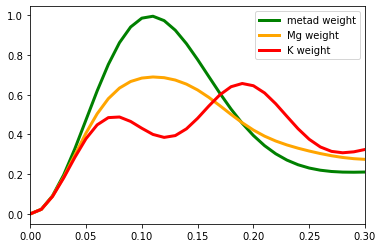

In [130]:
plt.plot(q,np.average(observables,axis=0,weights=weights)*q**2/
         np.max(avg_plum*q**2),lw=3,color='green',label='metad weight')   

plt.plot(q,np.average(observables,axis=0,weights=dict_maxent['MG','plumed_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_plum*q**2),
       lw=3,color='orange',label='Mg weight')
plt.plot(q,np.average(observables,axis=0,weights=dict_maxent['K','plumed_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_plum*q**2),
       lw=3,color='red',label='K weight')

plt.xlim(0,0.3)
plt.legend()
plt.show()

In the sollowing section, we repeat the same analyses shown above:

### Check peak/shoulder ratios

In [132]:
(crystal_after_mini_full_spectrum[10]*q[10]**2)/(crystal_after_mini_full_spectrum[20]*q[20]**2)

2.457418772986015

In [133]:
print('ratio crystal')
(np.average(observables,axis=0,weights=dict_maxent['crystal','plumed_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables,axis=0,weights=dict_maxent['crystal','plumed_4p','metad','singles','weights_me'])*q**2)[20]

ratio crystal


2.457422283761738

In [134]:
np.average((y_mg*x_mg**2)[69:90])/np.average((y_mg*x_mg**2)[169:190])

2.245962769409604

In [135]:
print('ratio MG')
(np.average(observables,axis=0,weights=dict_maxent['MG','plumed_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables,axis=0,weights=dict_maxent['MG','plumed_4p','metad','singles','weights_me'])*q**2)[20]

ratio MG


1.6200491879588224

In [136]:
np.average((y_k*x_mg**2)[69:90])/np.average((y_k*x_mg**2)[169:190])

1.4285539509989715

In [137]:
print('ratio K')
(np.average(observables,axis=0,weights=dict_maxent['K','plumed_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables,axis=0,weights=dict_maxent['K','plumed_4p','metad','singles','weights_me'])*q**2)[20]

ratio K


0.6682842693016048

### Weights

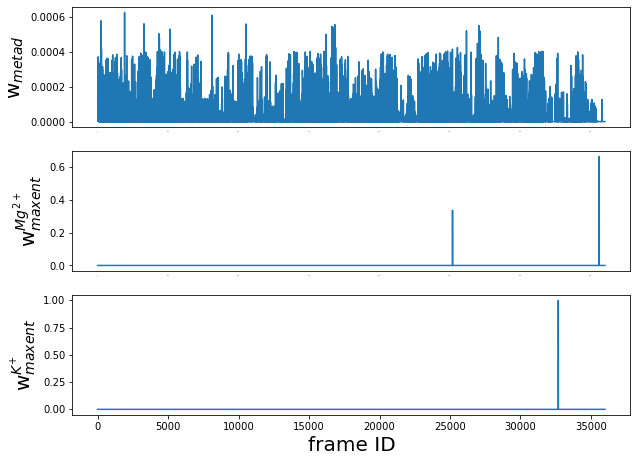

In [138]:
plt.figure(figsize=(10, 7.5))
plt.subplot(311)
plt.plot(weights)
plt.ylabel('w$_{metad}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)
plt.subplot(312)
plt.plot(dict_maxent['MG','plumed_4p','metad','singles','weights_me'])
plt.ylabel('w$_{maxent}^{Mg^{2+}}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)
plt.subplot(313)
plt.plot(dict_maxent['K','plumed_4p','metad','singles','weights_me'])
plt.ylabel('w$_{maxent}^{K^{+}}$',fontsize=20)
plt.xlabel('frame ID',fontsize=20)

plt.show()
#plt.savefig('SI_FIG_weights_plumed_spectra.png', format='png', dpi=300, bbox_inches='tight')

### Guinier fit on the reweighted spectra

In [139]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['MG','plumed_4p','metad','singles','weights_me'])[2:7]))

In [140]:
fitted_line = linefitline(q[2:7]**2)

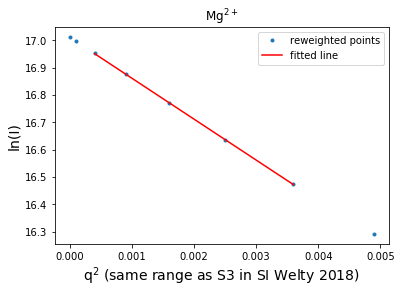

In [141]:
plt.plot(q[:8]**2,np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['MG','plumed_4p','metad','singles','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('Mg$^{2+}$')
plt.legend()
plt.show()

In [142]:
print('Guinier fit Rg* (exp. is 21.35):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 21.35):


21.168409153827742

In [143]:
print('weighted Rgcoord:')
np.average(metadb[1]*10,weights=dict_maxent['MG','plumed_4p','metad','singles','weights_me'])

weighted Rgcoord:


21.318777587693983

### Guinier fit on the reweighted spectra

In [144]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['K','plumed_4p','metad','singles','weights_me'])[2:7]))

In [145]:
fitted_line = linefitline(q[2:7]**2)

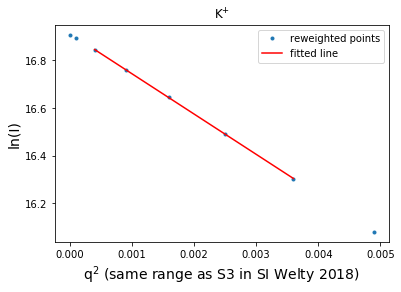

In [146]:
plt.plot(q[:8]**2,np.log(np.average(observables_Hum,axis=0,
        weights=dict_maxent['K','plumed_4p','metad','singles','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('K$^{+}$')
plt.legend()
plt.show()

In [147]:
print('Guinier fit Rg* (exp. is 25.17):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 25.17):


22.53475000136631

In [148]:
print('weighted Rgcoord:')
np.average(metadb[1]*10,weights=dict_maxent['K','plumed_4p','metad','singles','weights_me'])

weighted Rgcoord:


22.914029999999997

## Figure 3

__Short trajs (10 ns)__

In [30]:
# path='/scratch/mbernett/gtpase/keep_all_crystal/c_neutralize_with_MG/redo_with_opc_bigbox_differentMGconc/'

# # ALL PLUMED SPECTRA FOR THE SHORT TRAJS (10ns)
# paths=[path+"setup_KClONLY_2/production/test_plumed/",
#       path+"setup_2/production/test_plumed/",
#       path+"setup_MGneut_HALF_2/production/test_plumed/",
#       path+"setup_MGneut_ALL_2/production/test_plumed/"]

# names=["K","MG0","MGhalf","MGall"]

# shorts_spectra={} # plumed spectra for the short trajectories
# for i in range(len(paths)):
#     colvar_pl=np.loadtxt(paths[i]+'colvar',skiprows=1)[:,1:]
#     #avg_colv=np.average(colvar_pl,axis=0)
#     pl_spectr_I=np.zeros((1001,51))
#     pl_spectr_I[:,0]=colvar_pl[:,0] # just put identical to first value of the colvar (for q=0.01)
#     pl_spectr_I[:,1:]=colvar_pl[:,:]
#     shorts_spectra[names[i],"pl"]=np.array(pl_spectr_I*q**2)
    
# #ALL HUMMER SPECTRA FOR THE SHORT TRAJS (10ns)
# paths=[path+"setup_KClONLY_2/production/capriqorn_frame_by_frame_redo_with_average_dens/sphere40_shell7_singles/",
#       path+"setup_2/production/capriqorn_frame_by_frame_redo_with_average_dens/sphere40_shell7_singles/",
#       path+"setup_MGneut_HALF_2/production/capriqorn_frame_by_frame_redo_with_average_dens/sphere40_shell7_singles/",
#       path+"setup_MGneut_ALL_2/production/capriqorn_frame_by_frame_redo_with_average_dens/sphere40_shell7_singles/"]

# names=["K","MG0","MGhalf","MGall"]

# for i in range(len(paths)):
#     allI_Hum=[]
#     for j in range(1,1002):
#         allI_i=np.loadtxt(paths[i]+"dI_frame%s.dat" % j)[:,1]
#         allI_Hum.append(allI_i*q**2)
#     shorts_spectra[names[i],"hum"]=np.array(allI_Hum)

# # CRYSOL
# paths=[path+"setup_KClONLY_2/production/crysol_spectra_RNAonly/",
#       path+"setup_2/production/crysol_spectra_RNAonly/",
#       path+"setup_MGneut_HALF_2/production/crysol_spectra_RNAonly/",
#       path+"setup_MGneut_ALL_2/production/crysol_spectra_RNAonly/"]

# for i in range(len(paths)):
#     allI_cr=[]
#     for j in range(0,1001):
#         allI_i=np.loadtxt(paths[i]+"frame_00%04d00.int" % j,skiprows=1)[:,1]
#         allI_cr.append(allI_i*q**2)
#     shorts_spectra[names[i],"cr"]=np.array(allI_cr)
    
# # WAXSIS
# paths=[path+"setup_KClONLY_2/production/waxsis_spectra/",
#       path+"setup_2/production/waxsis_spectra/include_MG_and_K_in_scatter-itp/",
#       path+"setup_MGneut_HALF_2/production/waxsis_spectra/include_MG_and_K_in_scatter-itp/",
#       path+"setup_MGneut_ALL_2/production/waxsis_spectra/include_MG_and_K_in_scatter-itp/"]

# for i in range(len(paths)):
#     shorts_spectra[names[i],"waxs"]=np.loadtxt(paths[i]+'waxscalc_l_final.xvg',comments=['@','#','&'])[:,1]*q**2

In [226]:
# fname = "shorts_spectra.dat"
# pickle.dump(shorts_spectra,open(fname, "wb"))

In [33]:
shorts_spectra = pickle.load(open("./shorts_spectra.dat", "rb"))

In [34]:
for i in shorts_spectra:
    print(shorts_spectra[i].shape)

(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(1001, 51)
(51,)
(51,)
(51,)
(51,)


__Long trajs (1 microsec)__

In [31]:
# path='/scratch/mbernett/gtpase/redo_again_plain_MDs_spectra/'

# # ALL PLUMED SPECTRA FOR THE TRAJS (1 microsec)
# paths=[path+"KCl/spectra_plumed/cat_colvar_kcl.dat",
#       path+"MgKCl/spectra_plumed/cat_colvar_mgkcl.dat"]

# names=["K","MGall"]

# long_spectra={} # plumed spectra for the short trajectories
# for i in range(len(paths)):
#     colvar_pl=np.loadtxt(paths[i])
#     #avg_colv=np.average(colvar_pl,axis=0)
#     long_spectra[names[i],"pl"]=np.array(colvar_pl[:,5:]) # *q**2 if needed in the Kratky form
#     long_spectra[names[i],"Rg"]=np.array(colvar_pl[:,1])
#     long_spectra[names[i],"RMSD"]=np.array(colvar_pl[:,4])

# # SPHERES
# paths=[path+"KCl/spectra_hummer/check_sphere/2000_frames_scan_avg/",
#       path+"MgKCl/spectra_hummer/2000_frames_scan_avg/"]

# names=["K","MGall"] 

# #parts=1
# for i in range(len(names)):
#     for l in [7]: # [3,5,10,15]: # shell        
#         for j in [40]: # range(20,56,5): # radius R
#             allI_Hum=[]
#             for k in range(1,2001):
#                 try:
#                     allI_j=np.loadtxt(paths[i]+("sphere%02d_shell%s_singles/" % (j,l))+("dI_frame%s.dat" % k))[:,1]
#                     allI_Hum.append(allI_j) #*q**2)
#                 except OSError:
#                     pass
#             long_spectra[names[i],"hum_sphere%02d" % j,"shell%s" % l]=np.array(allI_Hum)
        

In [227]:
# fname = "longs_spectra.dat"
# pickle.dump(long_spectra,open(fname, "wb"))

In [35]:
long_spectra = pickle.load(open("./longs_spectra.dat", "rb"))

In [36]:
for i in long_spectra:
    print(long_spectra[i].shape)

(50008, 51)
(50008,)
(50008,)
(49772, 51)
(49772,)
(49772,)
(2000, 51)
(2000, 51)


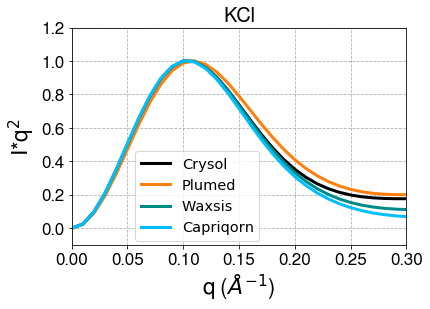

In [32]:
plt.plot(q,np.average(shorts_spectra["K","cr"],axis=0)/
         np.max(np.average(shorts_spectra["K","cr"],axis=0)),linewidth=3,label='Crysol',c='black')
plt.plot(q,np.average(shorts_spectra["K","pl"],axis=0)/
         np.max(np.average(shorts_spectra["K","pl"],axis=0)),linewidth=3,label='Plumed',c='C1')
plt.plot(q,shorts_spectra["K","waxs"]/
         np.max(shorts_spectra["K","waxs"]),linewidth=3,label='Waxsis',c='darkcyan')
plt.plot(q,np.average(shorts_spectra["K","hum"],axis=0)/
         np.max(np.average(shorts_spectra["K","hum"],axis=0)),linewidth=3,label='Capriqorn',c='deepskyblue')

plt.xlim(0,0.3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


plt.grid(axis='both', linestyle='--')
plt.legend()

plt.xlabel("q ($\AA^{-1}$)", fontname='FreeSans', fontsize=22)
plt.ylabel("I*q$^2$", fontname='FreeSans', fontsize=22)
plt.yticks(fontname = 'FreeSans', fontsize=17)
plt.xticks(fontname = 'FreeSans', fontsize=17)

plt.legend(fontsize=14.5,loc=(0.19,0.02))
plt.title("KCl",fontname = 'FreeSans', fontsize=20)
plt.ylim(-0.1,1.2)

plt.show()
#plt.savefig('FIG3_a_all_methods.png', format='png', dpi=300, bbox_inches="tight")

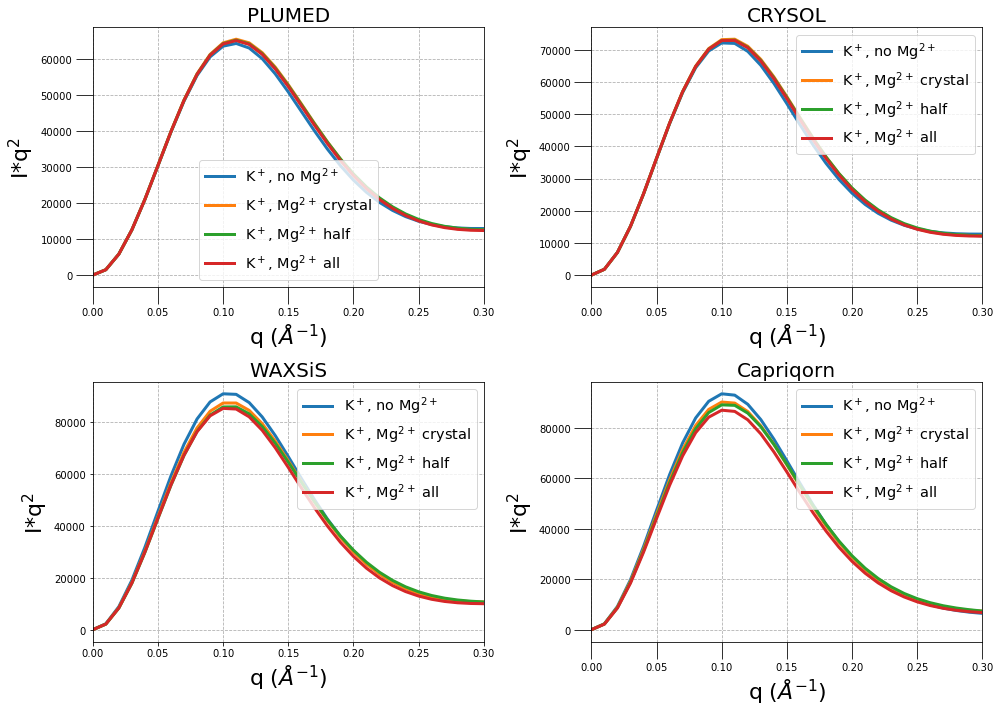

In [278]:
fig, axs = plt.subplots(2,2, figsize=(14, 10))
axs = axs.ravel()

titles=['PLUMED','CRYSOL','WAXSiS','Capriqorn']
names=np.array(list(shorts_spectra.keys()))[:4,0]
methods=['pl', 'cr', 'waxs', 'hum'] 
labels=['K$^+$, no Mg$^{2+}$',
       'K$^+$, Mg$^{2+}$ crystal',
       'K$^+$, Mg$^{2+}$ half',
       'K$^+$, Mg$^{2+}$ all']
# short spectra

for i in range(len(methods)):
    for j in range(len(names)):
        if methods[i] != 'waxs':
            axs[i].plot(q,np.average(shorts_spectra[names[j],methods[i]],axis=0),
                        linewidth=3,label=labels[j])
            
            axs[i].set_xlim(0,0.3)
            #axs[i].set_ticklabel_format(style='sci', axis='y', scilimits=(0,0))

            axs[i].grid(axis='both', linestyle='--')
            axs[i].legend(fontsize=14.5)
            axs[i].set_xlabel("q ($\AA^{-1}$)", fontsize=22)
            axs[i].set_ylabel("I*q$^2$", fontsize=22)
            axs[i].tick_params(size=17)
            #axs[i].set_xticklabels(fontsize=17)
            axs[i].set_title(titles[i], fontsize=20)
        else:
            axs[i].plot(q,shorts_spectra[names[j],methods[i]],
                        linewidth=3,label=labels[j])
            
            axs[i].set_xlim(0,0.3)
            #axs[i].set_ticklabel_format(style='sci', axis='y', scilimits=(0,0))

            axs[i].grid(axis='both', linestyle='--')
            axs[i].legend(fontsize=14.5)
            axs[i].set_xlabel("q ($\AA^{-1}$)",  fontsize=22)
            axs[i].set_ylabel("I*q$^2$", fontsize=22)
            #axs[i].set_yticklabels(fontsize=17)
            #axs[i].set_xticklabels(fontsize=17)
            axs[i].set_title(titles[i], fontsize=20)
            
fig.tight_layout()

#plt.subplots_adjust(right=1.4,top=4)
plt.show()
#plt.savefig('FIG_SI_all_methods_all_ionic_conditions.png', format='png', dpi=300, bbox_inches="tight")

In [33]:
histo_k = np.histogram(long_spectra['K',"Rg"], bins=100, range=(1,1.8),density=True)
histo_mg = np.histogram(long_spectra['MGall',"Rg"], bins=100, range=(1,1.8),density=True)

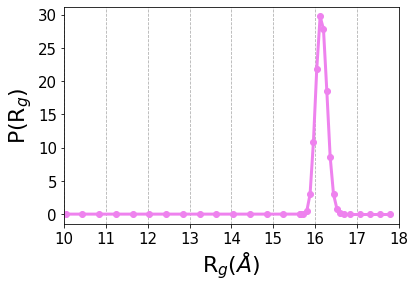

In [34]:
# plt.plot(((histo_mg[1][:-1]+histo_mg[1][1:])/2*10)[:75:5],histo_mg[0][:75:5],\
#          'o-',linewidth=3,color='black',label='Mg$^{2+}$')
# plt.plot(((histo_mg[1][:-1]+histo_mg[1][1:])/2*10)[85::3],histo_mg[0][85::3],\
#          'o-',linewidth=3,color='black')
# plt.plot(((histo_mg[1][:-1]+histo_mg[1][1:])/2*10)[70:84],histo_mg[0][70:84],\
#          'o-',linewidth=3,color='black')

plt.plot(((histo_k[1][:-1]+histo_k[1][1:])/2*10)[:75:5],histo_k[0][:75:5],\
         'o-',linewidth=3,color='violet',label='K$^{+}$')
plt.plot(((histo_k[1][:-1]+histo_k[1][1:])/2*10)[85::3],histo_k[0][85::3],\
         'o-',linewidth=3,color='violet')
plt.plot(((histo_k[1][:-1]+histo_k[1][1:])/2*10)[70:84],histo_k[0][70:84],\
         'o-',linewidth=3,color='violet')

#plt.plot((histo_mg[1][:-1]+histo_mg[1][1:])/2*10,histo_mg[0],'o-',linewidth=3,label='K$^{+}$')

plt.ylabel("P(R$_g$)", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('R$_g (\AA)$', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)

plt.xlim(10,18)

plt.grid(axis='x', linestyle='--')

#plt.legend(fontsize=14)
plt.show()
#plt.savefig('FIG3_b1_histo_Rg_unbiased_per_poster.png', format='png', dpi=300, bbox_inches="tight")
#plt.savefig('FIG3_b1_histo_Rg_unbiased.png', format='png', dpi=300, bbox_inches="tight")

In [35]:
histo_k_rmsd = np.histogram(long_spectra['K','RMSD']*10, bins=25, range=(0,3.5),density=True)
histo_mg_rmsd = np.histogram(long_spectra['MGall','RMSD']*10, bins=25, range=(0,3.5),density=True)
# NOTE! converted in Angstrom

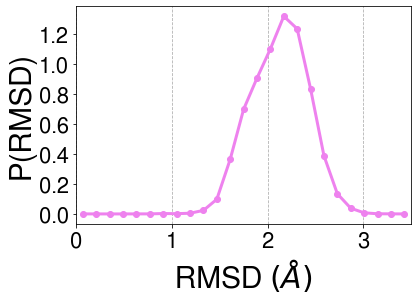

In [36]:
# plt.plot((histo_mg_rmsd[1][:-1]+histo_mg_rmsd[1][1:])/2, histo_mg_rmsd[0],
#          'o-',linewidth=3,color='black',label='MG')
plt.plot((histo_k_rmsd[1][:-1]+histo_k_rmsd[1][1:])/2,histo_k_rmsd[0],
         'o-',linewidth=3,color='violet',label='KCl')

plt.ylabel("P(RMSD)", fontname='FreeSans', fontsize=30)
plt.xlabel('RMSD $(\AA)$', fontname='FreeSans', fontsize=30)
plt.yticks(fontname = 'FreeSans', fontsize=22)
plt.xticks(np.linspace(0,4,5),fontname = 'FreeSans', fontsize=22)

#plt.axvline(x=0.8, color='gray', linestyle='--', linewidth=2)

plt.xlim(0,3.5)

plt.grid(axis='x', linestyle='--')
#plt.legend(fontsize=15)

plt.show()
#plt.savefig('FIG3_b2_histo_RMSD_unbiased_per_poster.png', format='png', dpi=300, bbox_inches="tight")
#plt.savefig('FIG3_b2_histo_RMSD_unbiased.png', format='png', dpi=300, bbox_inches="tight")

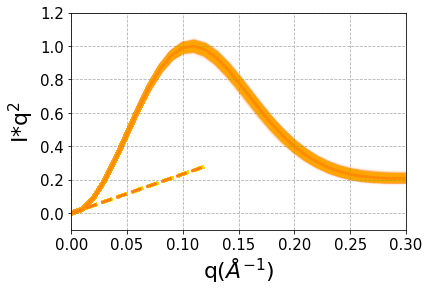

In [751]:
# done on the long trajectories
avg_plum=np.average(long_spectra["K","pl"],axis=0)

for i in range(0,len(long_spectra["K","pl"]),25): # stride 25 consistent to below
    plt.plot(q,long_spectra["K","pl"][i]*q**2/np.max(avg_plum*q**2),color='orange',lw=5,alpha=0.01)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[:2],
        long_spectra["K","pl"][i][:2]*q[:2]**2/np.max(avg_plum*q**2))
    fitted_line = linefitline(np.linspace(0,0.12,13))
    plt.plot(np.linspace(0,0.12,13),fitted_line,'--',color='gold',lw=3.05,alpha=0.1)

#plt.plot(q,long_spectra["K","pl"][0],color='grey',lw=3,label='singles')  

plt.plot(q,avg_plum*q**2/np.max(avg_plum*q**2),color='darkorange',lw=3,label='average')

# Line Fits:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[:2],
    np.average(long_spectra["K","pl"],axis=0)[:2]*q[:2]**2/np.max(avg_plum*q**2))
fitted_line = linefitline(np.linspace(0,0.12,13))

plt.plot(np.linspace(0,0.12,13),fitted_line,'--',lw=3,c='C1')

plt.ylabel("I*q$^2$", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('q$(\AA^{-1}$)', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.legend(fontsize=18,loc=(0.2,0.1))

plt.xlim(0,0.3)
plt.ylim(-0.1,1.2)
plt.grid(ls='--')

plt.show()
#plt.savefig('FIG3_c_nolabel_redone_newcolors.png', format='png', dpi=300, bbox_inches='tight')

In [38]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(long_spectra["K","pl"][::25],axis=0)[2:7]/
          np.average(long_spectra["K","pl"][::25],axis=0)[0]))
np.sqrt(-3*slope)

16.166399603406827

In [589]:
# error (bootstrap)
nb=5  # N blocks
nq=51 # 51 q points in each spectrum
spectra=copy.deepcopy(long_spectra["K","pl"][::25][:-1])
spectra=spectra.reshape((nb,-1,nq)) ## BLOCCHI
rgs_j=[]
for b in range(200):
    sample=spectra[np.random.choice(nb,size=nb)][:,:,:].reshape((-1,nq)) # re-sample by shuffling blocks
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(np.average(sample,axis=0)[2:7]/np.average(sample,axis=0)[0]))
    rgs_j.append(np.sqrt(-3*slope))
print('Error on the AVERAGE Rg*:',np.std(rgs_j))

Error on the AVERAGE Rg*: 0.014549111282316986


In [594]:
# stdev of the single values
rgstar_pl=[]
for i in range(len(long_spectra["K","pl"][::25][:-1])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(long_spectra["K","pl"][::25][:-1][i][2:7]/long_spectra["K","pl"][::25][:-1][i][0]))
    rgstar_pl.append(np.sqrt(-3*slope))
print('stdev of the single values:',np.std(rgstar_pl))

stdev of the single values: 0.11356333799460658


In [707]:
msds_plum=[]
for i in range(0,len(long_spectra["K","pl"]),25):    
    a=long_spectra["K","pl"][i]*q**2/np.max(avg_plum*q**2)
    b=avg_plum*q**2/np.max(avg_plum*q**2)
    msds_plum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_plum))

0.01047040218108441

In [708]:
msds_hum=[]
for i in range(len(long_spectra["K","hum_sphere40","shell7"])):    
    a=long_spectra["K","hum_sphere40","shell7"][i]*q**2/np.max(avg_hum*q**2)
    b=avg_hum*q**2/np.max(avg_hum*q**2)
    msds_hum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_hum))

0.02765973979562598

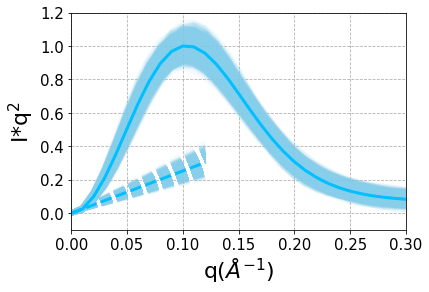

In [744]:
# temporary, done on the short trajectories
avg_hum=np.average(long_spectra["K","hum_sphere40","shell7"],axis=0)

for i in range(0,len(long_spectra["K","hum_sphere40","shell7"])):
    plt.plot(q,long_spectra["K","hum_sphere40","shell7"][i]*q**2/np.max(avg_hum*q**2),color='skyblue',lw=5,alpha=0.1)
    # Line Fits:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[:2],
        (long_spectra["K","hum_sphere40","shell7"][i]*q**2/np.max(avg_hum*q**2))[:2])
    fitted_line = linefitline(np.linspace(0,0.12,13))
    plt.plot(np.linspace(0,0.12,13),fitted_line,'--',color='skyblue',lw=3,alpha=0.1)
    
#plt.plot(q,np.average(long_spectra["K","hum_sphere40","shell7"],axis=0)*q**2,color='grey',lw=3,label='singles')
plt.plot(q,avg_hum*q**2/np.max(avg_hum*q**2),color='deepskyblue',lw=3,label='average')

# Line Fits:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[:2],
    (np.average(long_spectra["K","hum_sphere40","shell7"],axis=0)*q**2/np.max(avg_hum*q**2))[:2])
fitted_line = linefitline(np.linspace(0,0.12,13))

plt.plot(np.linspace(0,0.12,13),fitted_line,'--',lw=3,c='deepskyblue')

plt.ylabel("I*q$^2$", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('q$(\AA^{-1}$)', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.legend(fontsize=18,loc=(0.18,0.1))

plt.xlim(0,0.3)
plt.ylim(-0.1,1.2)
plt.grid(ls='--')


#plt.show()
plt.savefig('FIG3_d_nolabel_redone_newcolors.png', format='png', dpi=300, bbox_inches='tight')

In [43]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0)[2:7]/
          np.average(long_spectra["K","hum_sphere40","shell7"],axis=0)[0]))
np.sqrt(-3*slope)

16.7741999410505

In [597]:
# error (bootstrap)
nb=5  # N blocks
nq=51 # 51 q points in each spectrum
spectra=copy.deepcopy(long_spectra["K","hum_sphere40","shell7"])
spectra=spectra.reshape((nb,-1,nq)) ## BLOCCHI
rgs_j=[]
for b in range(200):
    sample=spectra[np.random.choice(nb,size=nb)][:,:,:].reshape((-1,nq)) # re-sample by shuffling blocks
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(np.average(sample,axis=0)[2:7]/np.average(sample,axis=0)[0]))
    rgs_j.append(np.sqrt(-3*slope))
print('Error on the AVERAGE Rg*:',np.std(rgs_j))

Error on the AVERAGE Rg*: 0.013650314660604438


In [599]:
# stdev of the single values
rgstar_hum=[]
for i in range(len(long_spectra["K","hum_sphere40","shell7"])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(long_spectra["K","hum_sphere40","shell7"][i][2:7]/long_spectra["K","hum_sphere40","shell7"][i][0]))
    rgstar_hum.append(np.sqrt(-3*slope))
print('stdev of the single values:',np.std(rgstar_hum))

stdev of the single values: 1.331450269991719


### Draw a sketch of the system

In the main text, we used a sketch representation of the system to indicate absence (by only showing the RNA heavy atoms) or presence (by showing the entire system: RNA heavy atoms, water oxygens and ions) of the solvent.  
Here we show how to generate such sketch images:

In [52]:
# path='/scratch/mbernett/gtpase/production_hrex_all_16_2d_redo_SAXSplumed_MARTINI_wallonratio/'
# solute=mdt.load(path+'npt_compact.gro')
# nframes=solute.n_frames

In [53]:
#solute.save_pdb('starting_structure_metad.pdb')

In [37]:
solute=mdt.load('./starting_structure_metad.pdb')
nframes=solute.n_frames
nframes

1

In [56]:
# fixing RNA topology (NAMES == ELEMENTS, 1st letter of the name)
RNA_index=[a.index for a in solute.top.atoms if a.residue.name in ['A','U','C','G']]
for i in RNA_index:
    solute.top.atom(i).name = solute.top.atom(i).name[0] # atom name

In [57]:
# change name to water Oxygens to distinguish them from solute Oxs
OW_index=[a.index for a in solute.top.atoms if a.residue.name=='HOH' and a.name=='O']
for i in OW_index:
    solute.top.atom(i).name = 'OW' # atom name

In [58]:
# largest sets at the end!
all_species=["C","N","P","O","K","CL","OW","MG"]
buffer_species=["K","CL","OW","MG"]

In [59]:
# RADIUS:
R=5.5 
xyz={}           
index={}
for i in all_species:
    xyz[i]=[]
    index[i]=[a.index for a in solute.top.atoms if a.name==i]
# center th system in the origin (0,0,0). This is done by computing the geom. center of RNA (actually, only 
# using all the P of RNA), and then subtracting it to the atoms in the system (only P and K considered here).
for i in range(nframes):
    center=np.average(solute.xyz[i,index["P"],:],axis=0) # format is: [frame,[atom_indices],[x,y,z]]
    # IT IS FINE USING THE P ONLY TO COMPUTE THE CENTER OF RNA. mbernett
    for s in all_species:
        xyz[s].append(solute.xyz[i,index[s],:]-center)

In [60]:
# discard atoms outside of sphere with radius R
def within_sphere(array,R):
    w=np.where(np.sum(array**2,axis=1)<R**2) # indices of atoms inside the sphere
    return array[w] # slice the original array: only keep elements with indices w

In [61]:
# SELECT ATOMS in sphere
for i in range(nframes):
    for species in xyz: # Iterating over a dictionary = iterating over its KEYS! list with xyz.keys()
        xyz[species][i]=within_sphere(xyz[species][i],R) # replace key values:
        # instead of the coordinates of all P atoms, keep only those laying inside a sphere with radius R

del species
del i

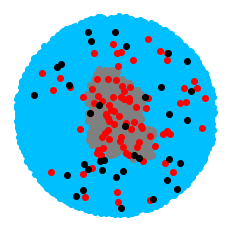

In [63]:
# set markersize=0 fo OW, K and MG to get the RNA-only picture
plt.plot(xyz["OW"][0][:,0],xyz["OW"][0][:,1], marker='o', color='deepskyblue',linewidth=0)
plt.plot(xyz["O"][0][:,0],xyz["O"][0][:,1], marker='o', color='gray', linewidth=0)
plt.plot(xyz["C"][0][:,0],xyz["C"][0][:,1], marker='o', color='gray', linewidth=0)
plt.plot(xyz["N"][0][:,0],xyz["N"][0][:,1], marker='o', color='gray', linewidth=0)
plt.plot(xyz["P"][0][:,0],xyz["P"][0][:,1], marker='o', color='gray', linewidth=0)
plt.plot(xyz["K"][0][:,0],xyz["K"][0][:,1], marker='o', color='red', linewidth=0)
plt.plot(xyz["CL"][0][:,0],xyz["CL"][0][:,1], marker='o', color='black', linewidth=0)
plt.plot(xyz["MG"][0][:,0],xyz["MG"][0][:,1], marker='o', color='yellow', linewidth=0)

plt.axis('square')
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.axis("off")

plt.show()
#plt.savefig('paper_FIG3_system_KCl.png', format='png', dpi=1000, bbox_inches='tight')

## Figure 4

In [200]:
#path='/scratch/mbernett/gtpase/production_hrex_all_16_2d_redo_SAXSplumed_MARTINI_wallonratio/reweight/'

In [201]:
#X, Y, Z = np.loadtxt(path+'./fes_180ns.dat', unpack=True)[:][0:3]

In [202]:
# fname = "xyz.dat"
# pickle.dump((X,Y,Z),open(fname, "wb"))

In [38]:
X, Y, Z = pickle.load(open("./xyz.dat", "rb"))

In [33]:
X = np.reshape(X, (296,189))
Y = np.reshape(Y, (296,189))
Z = np.reshape(Z, (296,189)) / 4.184

In [34]:
Z[Z>30] = np.nan

In [39]:
crystal_after_mini_all = pickle.load(open("./crystal_after_mini_full_spectrum.dat", "rb"))

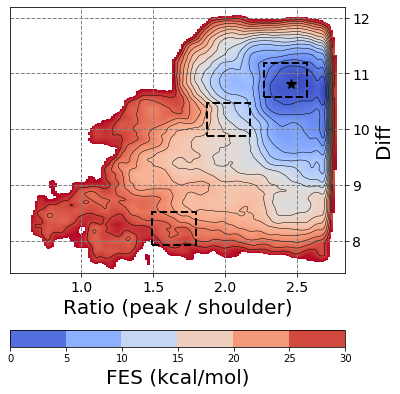

In [208]:
fig = plt.figure(figsize=(6,7))

ax = plt.axes()
levels = np.arange(0, 30, 2)

surf = ax.pcolormesh(X, Y, Z, cmap=cm.coolwarm) # , vmin=0, vmax=25

CS = ax.contour(X, Y, Z, levels, colors='black', linewidths=0.5)

plt.grid(axis='both', color='gray', linestyle='--', linewidth=1)

plt.colorbar(surf, boundaries=np.linspace(0,30,7),orientation="horizontal",pad=0.15).ax.set_xlabel('FES (kcal/mol)', fontsize=20)

plt.xlabel("Ratio (peak / shoulder)", fontsize=20)

plt.xticks(fontsize=14)

color=["#f0f0f0","#bdbdbd","#636363"]
labels=['1','2','3']

plt.ylim(7.417,12.2)

rect1 = Rectangle((2.2694, 10.5846),0.3,0.6,
                  linestyle = 'dashed',facecolor = 'None',edgecolor='black',lw=2,zorder=10)
plt.gca().add_patch(rect1)
rect2 = Rectangle((1.8710, 9.8732),0.3,0.6,
                  linestyle = 'dashed',facecolor = 'None',edgecolor='black',lw=2,zorder=10)
plt.gca().add_patch(rect2)
rect3 = Rectangle((1.4945, 7.9173),0.3,0.6,
                  linestyle = 'dashed',facecolor = 'None',edgecolor='black',lw=2,zorder=10)
plt.gca().add_patch(rect3)

plt.plot(crystal_after_mini_all[2],crystal_after_mini_all[3],marker='*',color='black',ms=10,label='crystal')

ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('right') #'both')
plt.yticks(fontsize=14)
ax.yaxis.set_label_position('right') #'both')
plt.ylabel("Diff", fontsize=20)

plt.show()
#plt.savefig('FIG4_fes_diff_ratio_3rectangles.png', format='png', dpi=300, bbox_inches="tight")

In [477]:
# block_1 (2.2694, 10.5846)
a=2.2694
b=10.5846
block_1_pl=observables[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]
block_1_hum=observables_Hum[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]
block_1_crys=observables_crys[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]

In [478]:
# block_2 (1.8710, 9.8732)
a=1.8710
b=9.8732
block_2_pl=observables[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]
block_2_hum=observables_Hum[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]
block_2_crys=observables_crys[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]

In [479]:
# block_3 (1.4945, 7.9173)
a=1.4945
b=7.9173
block_3_pl=observables[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]
block_3_hum=observables_Hum[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]
block_3_crys=observables_crys[np.where((metadb[2]>a) & (metadb[2]<(a+0.3)) & (metadb[3]>b) & (metadb[3]<(b+0.6)))]

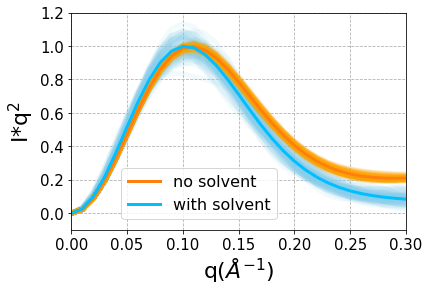

In [748]:
# CHECK

#plt.figure(figsize=[5.2, 4.8]) # default [6.4, 4.8]

for i in range(0,len(block_1_pl),100):
    plt.plot(q,block_1_hum[i]*q**2/np.max(avg_hum*q**2),color='skyblue',lw=5,alpha=0.1)
    
for i in range(0,len(block_1_pl),100):
    plt.plot(q,block_1_pl[i]*q**2/np.max(avg_plum*q**2),color='orange',lw=5,alpha=0.1)

# plt.plot(q,np.average(block_1_pl,axis=0)/
#          np.max(np.average(block_1_pl,axis=0)*q**2)*
#          np.max(np.average(block_1_hum,axis=0)*q**2)*q**2,color='C1',lw=3,label='no solvent')   
plt.plot(q,np.average(block_1_pl,axis=0)*q**2/np.max(avg_plum*q**2),color='C1',lw=3,label='no solvent')   

plt.plot(q,np.average(block_1_hum,axis=0)*q**2/np.max(avg_hum*q**2),color='deepskyblue',lw=3,label='with solvent')

plt.ylabel("I*q$^2$", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('q$(\AA^{-1}$)', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.legend(fontsize=18,loc=(0.18,0.1))


#plt.axis('square')
plt.xlim(0,0.3)
plt.ylim(-0.1,1.2)
plt.grid(ls='--')

plt.legend(loc=(0.15,0.05),fontsize=16)

plt.show()
#plt.savefig('FIG4_block1_redone_newcolors.png', format='png', dpi=300, bbox_inches="tight")

In [714]:
msds_plum=[]
for i in range(0,len(block_1_pl),25):    
    a=block_1_pl[i]*q**2/np.max(avg_plum*q**2)
    b=avg_plum*q**2/np.max(avg_plum*q**2)
    msds_plum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_plum))

0.012709666496173411

In [713]:
msds_hum=[]
for i in range(len(block_1_hum)):    
    a=block_1_hum[i]*q**2/np.max(avg_hum*q**2)
    b=avg_hum*q**2/np.max(avg_hum*q**2)
    msds_hum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_hum))

0.03314668729292865

In [482]:
# not on the long trajs but done on the compact from the metad, 500 frames
avg_crys=np.average(crys_extens['compact'],axis=0)

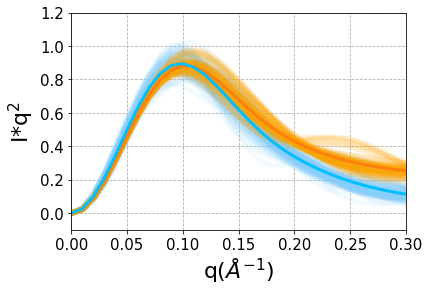

In [731]:
#plt.figure(figsize=[5.2, 4.8]) # default [6.4, 4.8]

for i in range(0,len(block_2_pl),10):
    plt.plot(q,block_2_hum[i]*q**2/np.max(avg_hum*q**2),color='lightskyblue',lw=5,alpha=0.1)
    
for i in range(0,len(block_2_pl),10):
    plt.plot(q,block_2_pl[i]*q**2/np.max(avg_plum*q**2),color='orange',lw=5,alpha=0.1)

plt.plot(q,np.average(block_2_pl,axis=0)*q**2/np.max(avg_plum*q**2),color='C1',lw=3)    

plt.plot(q,np.average(block_2_hum,axis=0)*q**2/np.max(avg_hum*q**2),color='deepskyblue',lw=3)

plt.ylabel("I*q$^2$", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('q$(\AA^{-1}$)', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.legend(fontsize=18,loc=(0.18,0.1))


#plt.axis('square')
plt.xlim(0,0.3)
plt.ylim(-0.1,1.2)
plt.grid(ls='--')

#plt.show()
plt.savefig('FIG4_block2_redone_newcolors.png', format='png', dpi=300, bbox_inches="tight")

In [715]:
msds_plum=[]
for i in range(0,len(block_2_pl),25):    
    a=block_2_pl[i]*q**2/np.max(avg_plum*q**2)
    b=avg_plum*q**2/np.max(avg_plum*q**2)
    msds_plum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_plum))

0.06651707477333484

In [716]:
msds_hum=[]
for i in range(len(block_2_hum)):    
    a=block_2_hum[i]*q**2/np.max(avg_hum*q**2)
    b=avg_hum*q**2/np.max(avg_hum*q**2)
    msds_hum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_hum))

0.06417410393568485

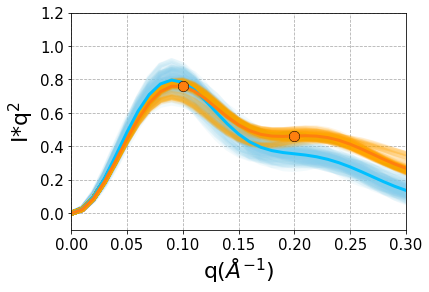

In [730]:
#plt.figure(figsize=[5.2, 4.8]) # default [6.4, 4.8]

for i in range(0,len(block_3_pl)):
    plt.plot(q,block_3_hum[i]*q**2/np.max(avg_hum*q**2),color='skyblue',lw=5,alpha=0.1)
    
for i in range(0,len(block_3_pl)):
    plt.plot(q,block_3_pl[i]*q**2/np.max(avg_plum*q**2),color='orange',lw=5,alpha=0.1)

plt.plot(q,np.average(block_3_hum,axis=0)*q**2/np.max(avg_hum*q**2),color='deepskyblue',lw=3,label='with solvent')
plt.plot(q,np.average(block_3_pl,axis=0)*q**2/np.max(avg_plum*q**2),color='C1',lw=3,label='no solvent')

plt.plot(q[10:21:10],(np.average(block_3_pl,axis=0)*q**2/np.max(avg_plum*q**2))[10:21:10],
         'o',color='black',ms=10,lw=3)
plt.plot(q[10:21:10],(np.average(block_3_pl,axis=0)*q**2/np.max(avg_plum*q**2))[10:21:10],
         'o',color='C1',ms=9,lw=3)

plt.ylabel("I*q$^2$", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('q$(\AA^{-1}$)', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.legend(fontsize=16,loc=(0.15,0.05))


#plt.axis('square')
plt.xlim(0,0.3)
plt.ylim(-0.1,1.2)
plt.grid(ls='--')

#plt.show()
plt.savefig('FIG4_block3_redone_newcolors.png', format='png', dpi=300, bbox_inches="tight")

In [719]:
msds_plum=[]
for i in range(0,len(block_3_pl),25):    
    a=block_3_pl[i]*q**2/np.max(avg_plum*q**2)
    b=avg_plum*q**2/np.max(avg_plum*q**2)
    msds_plum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_plum))

0.14081703694838413

In [720]:
msds_hum=[]
for i in range(len(block_3_hum)):    
    a=block_3_hum[i]*q**2/np.max(avg_hum*q**2)
    b=avg_hum*q**2/np.max(avg_hum*q**2)
    msds_hum.append(np.sum(((a-b)**2))/len(b))
np.sqrt(np.average(msds_hum))

0.12115817162883855

## Draw spheres and shell widths

Using the same idea of sketch images shown above, we use this representation to show the selection of Capriqorn parameters to compute the SAXS spectra that include explicitly the contribution from the solvent. Such parameters are the radius of a sphere including the solute and the surrounding solvent, and a shell width that includes only solvent and that is used bu the software to perform the solvent matching.  
  
To see the resulting drawing, just execute ONE of the 3 numbered section below (1., 2. or 3.) and then jump to the "Execute this to display:" section.

1. Sample snapshot from plain MD:

In [37]:
# ## plain MD
# path='/scratch/mbernett/gtpase/redo_again_plain_MDs_spectra/KCl/spectra_hummer/'

# solute=mdt.load(path+'check_sphere/traj_centered_1microsec_skip8.xtc',
#                 top=path+'check_sphere/pdb_centered.pdb') #[::100] LOAD TRAJ SKIPPING!
# nframes=solute.n_frames
# nframes

250

In [38]:
#solute[0].save_pdb('./solute_plainMD.pdb')

In [40]:
solute=mdt.load('./solute_plainMD.pdb')
nframes=solute.n_frames
nframes

1

2. Sample snapshot from metad with RNA structural compactness comparable to plain MD:

In [41]:
# ## metad compact
# path='/scratch/mbernett/gtpase/redo_again_plain_MDs_spectra/KCl/spectra_hummer/'

# solute=mdt.load(path+'check_sphere_on_metad/metad_similar_plainMD_NOMW_centered_skip2.xtc',
#                 top=path+'check_sphere_on_metad/pdb_centered.pdb') #[::100] LOAD TRAJ SKIPPING!
# nframes=solute.n_frames
# nframes

263

In [42]:
#solute[0].save_pdb('./solute_metad_compact.pdb')

In [43]:
solute=mdt.load('./solute_metad_compact.pdb')
nframes=solute.n_frames
nframes

1

3. Sample snapshot from metad with low RNA structural compactness (extended structure):

In [44]:
# ## metad extended extreme
# path='/scratch/mbernett/gtpase/redo_again_plain_MDs_spectra/KCl/spectra_hummer/'

# solute=mdt.load(path+'check_sphere_on_metad/metad_extended_structures_extremes_NOMW_centered.xtc',
#                 top=path+'check_sphere_on_metad/pdb_centered.pdb') #[::100] LOAD TRAJ SKIPPING!
# nframes=solute.n_frames 
# nframes

28

In [45]:
#solute[0].save_pdb('./solute_metad_extended_extreme.pdb')

In [46]:
solute=mdt.load('./solute_metad_extended_extreme.pdb')
nframes=solute.n_frames
nframes

1

Execute this to display:

In [47]:
## fixing RNA topology (NAMES == ELEMENTS, 1st letter)
RNA_index=[a.index for a in solute.top.atoms if a.residue.name in ['A','U','C','G']]
for i in RNA_index:
    solute.top.atom(i).name = solute.top.atom(i).name[0] # atom name
#[a.name for a in solute.top.atoms if a.index < 1833]

## RENAMING WATER OXYGENS
OW_index=[a.index for a in solute.top.atoms if a.residue.name=='HOH' and a.name=='O']
for i in OW_index:
    solute.top.atom(i).name = 'OW' # atom name
    
## largest sets at the end!
all_species=["C","N","P","O","K","CL","OW","MG"]
buffer_species=["K","CL","OW","MG"]

In [48]:
# Here we center the whole trajectory
xyz_cen={}           
index={}
for i in all_species:
    xyz_cen[i]=[]
    index[i]=[a.index for a in solute.top.atoms if a.name==i]

# center th system in the origin (0,0,0). This is done by computing the geom. center of RNA (actually, only 
# using all the P of RNA), and then subtracting it to the atoms in the system (only P and K considered here).
for i in range(nframes):
    center=np.average(solute.xyz[i,index["P"],:],axis=0) # format is: [frame,[atom_indices],[x,y,z]]
    # IT IS FINE USING THE P ONLY TO COMPUTE THE CENTER OF RNA. mbernett
    for s in all_species:
        xyz_cen[s].append(solute.xyz[i,index[s],:]-center)

In [49]:
# discard atoms outside of sphere with radius R
def within_sphere(array,R):
    w=np.where(np.sum(array**2,axis=1)<R**2) # indices of atoms inside the sphere
    return array[w] # slice the original array: only keep elements with indices w

In [50]:
# Here we select atoms within a certain radius
spheres=[40,45,50,55,60,65,70]

system_spheres={}
for i in range(len(spheres)):
    R_temp=spheres[i]/10 # define the sphere in nm
    # SELECT ATOMS in sphere
    xyz_sel=copy.deepcopy(xyz_cen) # !!! ESSENTIAL!
    for j in range(nframes):
        for species in xyz_sel: # Iterating over a dictionary = iterating over its KEYS! list with xyz.keys()
            xyz_sel[species][j]=within_sphere(xyz_sel[species][j],R_temp) # replace key values:
            # instead of the coordinates of all P atoms, keep only those laying inside a sphere with radius R   
    system_spheres[spheres[i]]=xyz_sel 

System cut at 55 Ang radius from center {0,0,0}
SAXS radius=54.0 Ang and shell_width=10.0 Ang


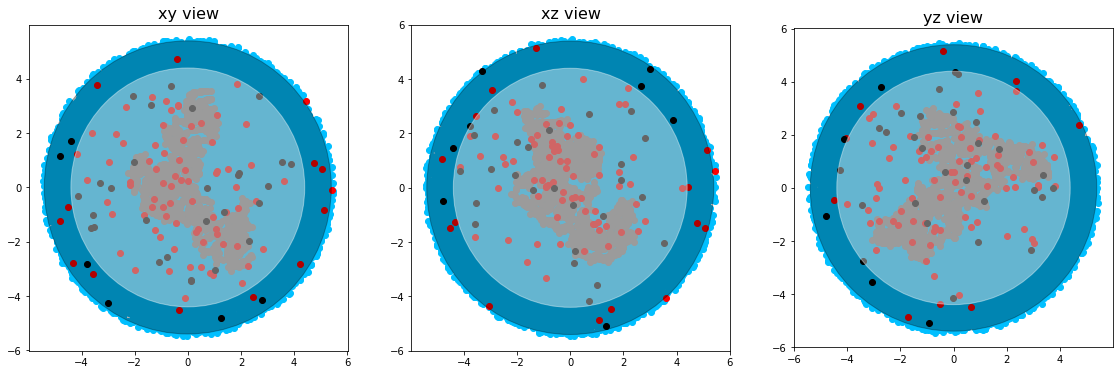

In [224]:
# NOTE: 
ss=55 # sphere radius
# plain MD and metad compact
rad=4.0
sh=0.7
# metad extended extreme
rad=5.4
sh=1.0

print('System cut at %s Ang radius from center {0,0,0}' % ss)
print('SAXS radius=%s Ang and shell_width=%s Ang' % (rad*10,sh*10))
fig, axs = plt.subplots(1,3, figsize=(14, 6))
axs = axs.ravel()

fr=0 # np.where(colv_avg_scan_metad_e[:,1]>2.3)[0][9] # frame index
persp=np.array([[0,1],[0,2],[1,2]]) # 0,1,2 = x,y,z
ax_view=['xy','xz','yz']
species_layer=["OW","O","C","N","P","K","CL","MG"]
colors=['deepskyblue','gray','gray','gray','gray','red','black','yellow']
linew=[0,0,0,0,0,0,0,0]

for i in range(3):
    #plt.subplot(1,3,i+1)
    persp_i=persp[i]
    for j in range(len(species_layer)):
        #plt.subplot()
        axs[i].plot(system_spheres[ss][species_layer[j]][fr][:,persp_i[0]],
                 system_spheres[ss][species_layer[j]][fr][:,persp_i[1]],
                 marker='o',color=colors[j],linewidth=linew[j])

        ## draw circles
    circle_1=plt.Circle((0, 0),rad,color='black',zorder=4,alpha=0.3)
    circle_2=plt.Circle((0, 0),rad-sh,color='white',zorder=5,alpha=0.4)
    axs[i].add_artist(circle_1)
    axs[i].add_artist(circle_2)
    axs[i].set_title('%s view' % ax_view[i],fontsize=16)

    plt.axis('square')
# #plt.tick_params(axis='both', labelsize=0, length = 0)
# #plt.axis("off")
plt.subplots_adjust(right=1.2)
plt.show()
#plt.savefig('paper_FIGSI_system_xyz_plainMD.png', format='png', dpi=300, bbox_inches='tight')
#plt.savefig('paper_FIGSI_system_xyz_metad_compact.png', format='png', dpi=300, bbox_inches='tight')
#plt.savefig('paper_FIGSI_system_xyz_metad_extended_extreme.png', format='png', dpi=300, bbox_inches='tight')

##  PLUMED spectra: compare all-atom vs MARTINI

In [40]:
martini=np.loadtxt('./colvar_martini_long')[:,1:52]
all_atom=np.loadtxt('./colvar_all_atom_long')[:,1:52]

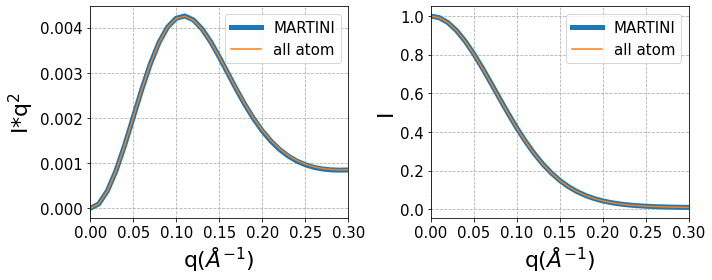

In [41]:
plt.figure(figsize=(10, 4))
# choose random frame for comparison
randfr=np.random.randint(0,martini.shape[0])
#
plt.subplot(121)
plt.plot(q,martini[randfr]*q**2,lw=5,label='MARTINI')
plt.plot(q,all_atom[randfr]*q**2,label='all atom')
plt.ylabel("I*q$^2$", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('q$(\AA^{-1}$)', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xlim(0,0.3)
plt.grid(ls='--')
plt.legend(fontsize=15)

plt.subplot(122)
plt.plot(q,martini[randfr],lw=5,label='MARTINI')
plt.plot(q,all_atom[randfr],label='all atom')
plt.ylabel("I", fontname='DejaVu Sans', fontsize=22)
plt.xlabel('q$(\AA^{-1}$)', fontname='DejaVu Sans', fontsize=22)
plt.yticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xticks(fontname = 'DejaVu Sans', fontsize=15)
plt.xlim(0,0.3)
plt.grid(ls='--')
plt.legend(fontsize=15)

#plt.subplots_adjust(right=1.3)
plt.tight_layout()

plt.show()
#plt.savefig('FIG_SI_martini_vs_all_atom.png', format='png', dpi=300, bbox_inches="tight")

## Reweighting through maxent enforcing 4 points: unbiased-MD spectra

Here we perform reweighting using as input observables the SAXS spectra compute with Capriqorn from a long unbiased MD simulation.

In [421]:
names=['metad','MG','K']
e_series=np.array([[np.average(observables_Hum,axis=0,weights=weights)[3],
                    np.average(observables_Hum,axis=0,weights=weights)[5],
                   np.average(observables_Hum,axis=0,weights=weights)[10],
                    np.average(observables_Hum,axis=0,weights=weights)[20]],
                   [y_mg[9],y_mg[29],np.average(y_mg[69:90]),np.average(y_mg[169:190])],
                   [y_k[9],y_k[29],np.average(y_k[69:90]),np.average(y_k[169:190])]])

In [422]:
q[2:7],x_mg[:41]

(array([0.02, 0.03, 0.04, 0.05, 0.06]),
 array([0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,
        0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038,
        0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047,
        0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056,
        0.057, 0.058, 0.059, 0.06 , 0.061]))

In [423]:
q[[3,5,10,20]],x_mg[[9,29,79,179]]

(array([0.03, 0.05, 0.1 , 0.2 ]), array([0.03, 0.05, 0.1 , 0.2 ]))

In [19]:
# with regularization hard-coded inside
def weights_prop(l,metadb,observables,e):
    l = np.array(l)
    weight_all = metadb / 2.5 # metadb[-1] / 2.5
    obs_prop=observables - np.outer(np.sum(observables,axis=1),e)/np.sum(e)
    #print(observables[0],obs_prop[0])
    
    weight_all -= np.dot(obs_prop,l) # calcolo esponente della formula del maxent
    shift_all = np.max(weight_all) # da sottrarre per evitare il solito problema dell'overflow
    weight_all = np.exp(weight_all - shift_all) # uso l'esponente calcolato sopra per ottenere i pesi
    
    return weight_all/ np.sum(weight_all)

def Gamma_prop(l,metadb,observables,e):
    l = np.array(l)
    weight_all = metadb / 2.5 # metadb[-1] / 2.5
    obs_prop=observables - np.outer(np.sum(observables,axis=1),e)/np.sum(e)
    #print(observables[0],obs_prop[0])
    
    weight_all -= np.dot(obs_prop,l) # calcolo esponente della formula del maxent
    shift_all = np.max(weight_all) # da sottrarre per evitare il solito problema dell'overflow
    weight_all = np.exp(weight_all - shift_all) # uso l'esponente calcolato sopra per ottenere i pesi
    
    weight_mt = metadb / 2.5 # metadb[-1] / 2.5
    shift_mt = np.max(weight_mt)
    weight_mt = np.exp(weight_mt - shift_mt)
    
    f = np.log(np.sum(weight_all) / np.sum(weight_mt)) + shift_all - shift_mt
    der = - np.dot(weight_all,obs_prop) / np.sum(weight_all) # derivative with respect to l
    
    sigma=1e-10 # UNITS OF THE OBSERVABLES. Set to 1e-10 to set it to zero.
    reg=sigma**2
    f+=0.5*np.sum(reg*l**2)
    der+=reg*l
    return(f,der)

In [432]:
metadb_fake=np.zeros(long_spectra["K","hum_sphere40","shell7"].shape[0])
metadb_fake.shape

(2000,)

In [437]:
kish_series_Hum = []
weights_me_save_Hum = []

factor=1/1000 # div observables for a big number for numeric reas (we care about ratios, not a problem doing so)
for i in range(len(names)):
    res_prop_i = minimize(Gamma_prop, np.array((0.0,0.0,0.0,0.0)), method='BFGS',tol=1e-10,jac=True,
               args=(metadb_fake,factor*long_spectra["K","hum_sphere40","shell7"][:,[3,5,10,20]],e_series[i]))
    w_prop_i = weights_prop(res_prop_i.x,metadb_fake,factor*long_spectra["K","hum_sphere40","shell7"][:,[3,5,10,20]],e_series[i])
    kish_i = 1 / np.sum(w_prop_i**2)
    ###
    dict_maxent[names[i],'hummer_4p','unbiased','e_ratios']=e_series[i,2]/e_series[i,3]
    dict_maxent[names[i],'hummer_4p','unbiased','kish_sizes']=kish_i
    dict_maxent[names[i],'hummer_4p','unbiased','weights_me']=w_prop_i
    dict_maxent[names[i],'hummer_4p','unbiased','lagr_mult']=res_prop_i.x   

In [438]:
print('Kish sizes:')
print('metad',dict_maxent['metad','hummer_4p','unbiased','kish_sizes'])
print('MG',dict_maxent['MG','hummer_4p','unbiased','kish_sizes'])
print('K',dict_maxent['K','hummer_4p','unbiased','kish_sizes'])

Kish sizes:
metad 1704.4702989583516
MG 2.0
K 1.0


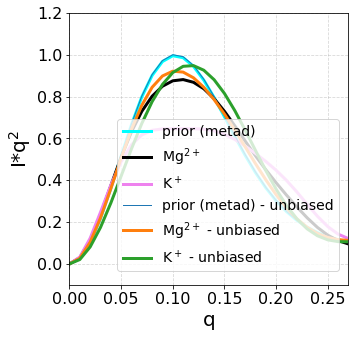

In [442]:
plt.figure(figsize=(5,5))

plt.plot(q,np.average(observables_Hum,axis=0,
                      weights=dict_maxent['metad','hummer_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,color='cyan',label='prior (metad)')
plt.plot(q,np.average(observables_Hum,axis=0,
                      weights=dict_maxent['MG','hummer_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,color='black',label='Mg$^{2+}$')
plt.plot(q,np.average(observables_Hum,axis=0,
                      weights=dict_maxent['K','hummer_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,color='violet',label='K$^+$')

plt.plot(q,np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
                      weights=dict_maxent['metad','hummer_4p','unbiased','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=1,label='prior (metad) - unbiased')
plt.plot(q,np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
                      weights=dict_maxent['MG','hummer_4p','unbiased','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,label='Mg$^{2+}$ - unbiased')
plt.plot(q,np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
                      weights=dict_maxent['K','hummer_4p','unbiased','weights_me'])*q**2/
         np.max(avg_hum*q**2),lw=3,label='K$^+$ - unbiased')
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('q',fontsize=20)
plt.ylabel('I*q$^2$',fontsize=20)
plt.xlim(0,0.27)
plt.grid(ls='--',alpha=0.5)

plt.ylim(-0.1,1.2)
plt.legend(fontsize=14,loc=(0.17,0.05))
plt.show()
#plt.savefig('FIGSI_all_reweighted_with_crystal.png', format='png', dpi=300, bbox_inches='tight')

In [51]:
# Lagrange multipliers
dict_maxent['MG','hummer_4p','metad','singles','lagr_mult'],\
dict_maxent['K','hummer_4p','metad','singles','lagr_mult']

(array([ 0.00748749,  0.01209229,  0.0120473 , -0.03162708]),
 array([ 0.00387421,  0.02486891,  0.00930744, -0.03805056]))

Here below we conduct the same analyses as done above after reweighting:

### Check peak/shoulder ratios

In [446]:
(np.average(observables_Hum,axis=0,weights=weights)[10]*q[10]**2)/\
(np.average(observables_Hum,axis=0,weights=weights)[20]*q[20]**2)

3.2985023257963553

In [58]:
weights.shape

(36001,)

In [444]:
print('ratio metad')
(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
            weights=dict_maxent['metad','hummer_4p','unbiased','weights_me'])*q**2)[10]/\
(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
            weights=dict_maxent['metad','hummer_4p','unbiased','weights_me'])*q**2)[20]

ratio metad


3.298502325796318

In [445]:
np.average((y_mg*x_mg**2)[69:90])/np.average((y_mg*x_mg**2)[169:190])

2.245962769409604

In [447]:
print('ratio MG')
(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
            weights=dict_maxent['MG','hummer_4p','unbiased','weights_me'])*q**2)[10]/\
(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
            weights=dict_maxent['MG','hummer_4p','unbiased','weights_me'])*q**2)[20]

ratio MG


2.7856193088063472

In [448]:
np.average((y_k*x_mg**2)[69:90])/np.average((y_k*x_mg**2)[169:190])

1.4285539509989715

In [449]:
print('ratio K')
(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
            weights=dict_maxent['K','hummer_4p','unbiased','weights_me'])*q**2)[10]/\
(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
            weights=dict_maxent['K','hummer_4p','unbiased','weights_me'])*q**2)[20]

ratio K


2.560938651058844

### Weights

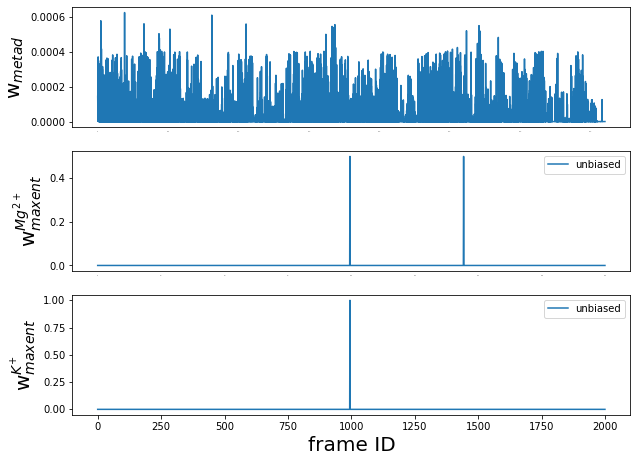

In [450]:
plt.figure(figsize=(10, 7.5))
plt.subplot(311)
plt.plot(weights)
plt.ylabel('w$_{metad}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)

plt.subplot(312)
plt.plot(dict_maxent['MG','hummer_4p','unbiased','weights_me'],label='unbiased')
plt.ylabel('w$_{maxent}^{Mg^{2+}}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)
plt.legend()

plt.subplot(313)
plt.plot(dict_maxent['K','hummer_4p','unbiased','weights_me'],label='unbiased')
plt.ylabel('w$_{maxent}^{K^{+}}$',fontsize=20)
plt.xlabel('frame ID',fontsize=20)
plt.legend()

plt.show()
#plt.savefig('SI_FIG_weights_hummer_spectra_redone.png', format='png', dpi=300, bbox_inches='tight')

### Guinier fit on the reweighted spectra

In [451]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
        weights=dict_maxent['MG','hummer_4p','unbiased','weights_me'])[2:7]))

In [452]:
fitted_line = linefitline(q[2:7]**2)

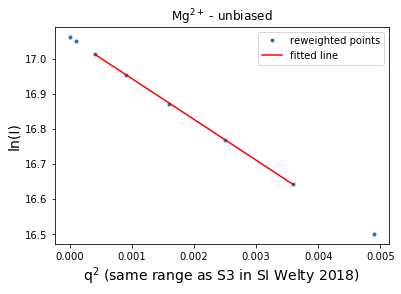

In [453]:
plt.plot(q[:8]**2,np.log(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
        weights=dict_maxent['MG','hummer_4p','unbiased','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('Mg$^{2+}$ - unbiased')
plt.legend()
plt.show()

In [454]:
print('Guinier fit Rg* (exp. is 21.35):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 21.35):


18.667173795270156

In [461]:
long_spectra["K","Rg"].shape

(50008,)

In [456]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
        weights=dict_maxent['K','hummer_4p','unbiased','weights_me'])[2:7]))

In [457]:
fitted_line = linefitline(q[2:7]**2)

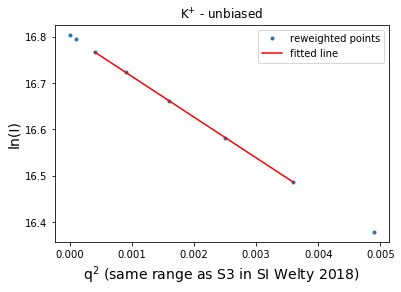

In [458]:
plt.plot(q[:8]**2,np.log(np.average(long_spectra["K","hum_sphere40","shell7"],axis=0,
        weights=dict_maxent['K','hummer_4p','unbiased','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('K$^{+}$ - unbiased')
plt.legend()
plt.show()

In [459]:
print('Guinier fit Rg* (exp. is 25.17):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 25.17):


16.225914577785197

## Reweighting through maxent enforcing 4 points: crysol spectra

Here we perform reweighting using as input observables the SAXS spectra compute with Crysol.

In [515]:
names=['metad','MG','K']
e_series=np.array([[np.average(observables_crys,axis=0,weights=weights)[3],
                    np.average(observables_crys,axis=0,weights=weights)[5],
                   np.average(observables_crys,axis=0,weights=weights)[10],
                    np.average(observables_crys,axis=0,weights=weights)[20]],
                   [y_mg[9],y_mg[29],np.average(y_mg[69:90]),np.average(y_mg[169:190])],
                   [y_k[9],y_k[29],np.average(y_k[69:90]),np.average(y_k[169:190])]])

In [507]:
observables_crys.shape

(36001, 51)

In [509]:
q[2:7],x_mg[:41]

(array([0.02, 0.03, 0.04, 0.05, 0.06]),
 array([0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,
        0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038,
        0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047,
        0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056,
        0.057, 0.058, 0.059, 0.06 , 0.061]))

In [510]:
q[[3,5,10,20]],x_mg[[9,29,79,179]]

(array([0.03, 0.05, 0.1 , 0.2 ]), array([0.03, 0.05, 0.1 , 0.2 ]))

In [514]:
# with regularization hard-coded inside
def weights_prop(l,metadb,observables,e):
    l = np.array(l)
    weight_all = metadb / 2.5 # metadb[-1] / 2.5
    obs_prop=observables - np.outer(np.sum(observables,axis=1),e)/np.sum(e)
    #print(observables[0],obs_prop[0])
    
    weight_all -= np.dot(obs_prop,l) # calcolo esponente della formula del maxent
    shift_all = np.max(weight_all) # da sottrarre per evitare il solito problema dell'overflow
    weight_all = np.exp(weight_all - shift_all) # uso l'esponente calcolato sopra per ottenere i pesi
    
    return weight_all/ np.sum(weight_all)

def Gamma_prop(l,metadb,observables,e):
    l = np.array(l)
    weight_all = metadb / 2.5 # metadb[-1] / 2.5
    obs_prop=observables - np.outer(np.sum(observables,axis=1),e)/np.sum(e)
    #print(observables[0],obs_prop[0])
    
    weight_all -= np.dot(obs_prop,l) # calcolo esponente della formula del maxent
    shift_all = np.max(weight_all) # da sottrarre per evitare il solito problema dell'overflow
    weight_all = np.exp(weight_all - shift_all) # uso l'esponente calcolato sopra per ottenere i pesi
    
    weight_mt = metadb / 2.5 # metadb[-1] / 2.5
    shift_mt = np.max(weight_mt)
    weight_mt = np.exp(weight_mt - shift_mt)
    
    f = np.log(np.sum(weight_all) / np.sum(weight_mt)) + shift_all - shift_mt
    der = - np.dot(weight_all,obs_prop) / np.sum(weight_all) # derivative with respect to l
    
    sigma=1e-10 # UNITS OF THE OBSERVABLES. Set to 1e-10 to set it to zero.
    reg=sigma**2
    f+=0.5*np.sum(reg*l**2)
    der+=reg*l
    return(f,der)

In [516]:
factor=1/1000 # div observables for a big number for numeric reas (we care about ratios, not a problem doing so)
for i in range(len(names)):
    res_prop_i = minimize(Gamma_prop, np.array((0.0,0.0,0.0,0.0)), method='BFGS',tol=1e-10,jac=True,
               args=(metadb[-1],factor*observables_crys[:,[3,5,10,20]],e_series[i]))
    w_prop_i = weights_prop(res_prop_i.x,metadb[-1],factor*observables_crys[:,[3,5,10,20]],e_series[i])
    kish_i = 1 / np.sum(w_prop_i**2)
    ###
    dict_maxent[names[i],'crysol_4p','metad','singles','e_ratios']=e_series[i,2]/e_series[i,3]
    dict_maxent[names[i],'crysol_4p','metad','singles','kish_sizes']=kish_i
    dict_maxent[names[i],'crysol_4p','metad','singles','weights_me']=w_prop_i
    dict_maxent[names[i],'crysol_4p','metad','singles','lagr_mult']=res_prop_i.x   

In [517]:
print('Kish sizes:')
print('metad',dict_maxent['metad','crysol_4p','metad','singles','kish_sizes'])
print('MG',dict_maxent['MG','crysol_4p','metad','singles','kish_sizes'])
print('K',dict_maxent['K','crysol_4p','metad','singles','kish_sizes'])

Kish sizes:
metad 5690.937864373405
MG 1.0
K 1.0


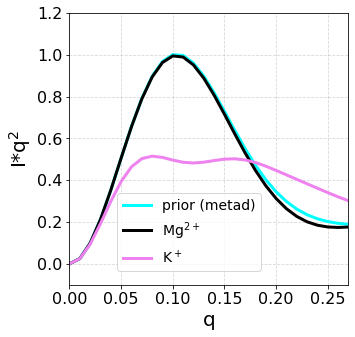

In [519]:
plt.figure(figsize=(5,5))

plt.plot(q,np.average(observables_crys,axis=0,
                      weights=dict_maxent['metad','crysol_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_crys*q**2),lw=3,color='cyan',label='prior (metad)')
plt.plot(q,np.average(observables_crys,axis=0,
                      weights=dict_maxent['MG','crysol_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_crys*q**2),lw=3,color='black',label='Mg$^{2+}$')
plt.plot(q,np.average(observables_crys,axis=0,
                      weights=dict_maxent['K','crysol_4p','metad','singles','weights_me'])*q**2/
         np.max(avg_crys*q**2),lw=3,color='violet',label='K$^+$')
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('q',fontsize=20)
plt.ylabel('I*q$^2$',fontsize=20)
plt.xlim(0,0.27)
plt.grid(ls='--',alpha=0.5)

plt.ylim(-0.1,1.2)
plt.legend(fontsize=14,loc=(0.17,0.05))
plt.show()
#plt.savefig('FIGSI_all_reweighted_with_crystal.png', format='png', dpi=300, bbox_inches='tight')

Here below we conduct the same analyses as done above after reweighting:

### Check peak/shoulder ratios

In [520]:
(np.average(observables_crys,axis=0,weights=weights)[10]*q[10]**2)/\
(np.average(observables_crys,axis=0,weights=weights)[20]*q[20]**2)

2.9033731913008114

In [521]:
print('ratio metad')
(np.average(observables_crys,axis=0,weights=dict_maxent['metad','crysol_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables_crys,axis=0,weights=dict_maxent['metad','crysol_4p','metad','singles','weights_me'])*q**2)[20]

ratio metad


2.903373191300814

In [522]:
np.average((y_mg*x_mg**2)[69:90])/np.average((y_mg*x_mg**2)[169:190])

2.245962769409604

In [538]:
x_mg[[79,179]]

array([0.1, 0.2])

In [523]:
print('ratio MG')
(np.average(observables_crys,axis=0,weights=dict_maxent['MG','crysol_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables_crys,axis=0,weights=dict_maxent['MG','crysol_4p','metad','singles','weights_me'])*q**2)[20]

ratio MG


3.1822477418753246

In [524]:
np.average((y_k*x_mg**2)[69:90])/np.average((y_k*x_mg**2)[169:190])

1.4285539509989715

In [525]:
print('ratio K')
(np.average(observables_crys,axis=0,weights=dict_maxent['K','crysol_4p','metad','singles','weights_me'])*q**2)[10]/\
(np.average(observables_crys,axis=0,weights=dict_maxent['K','crysol_4p','metad','singles','weights_me'])*q**2)[20]

ratio K


1.1105667110546023

### Weights

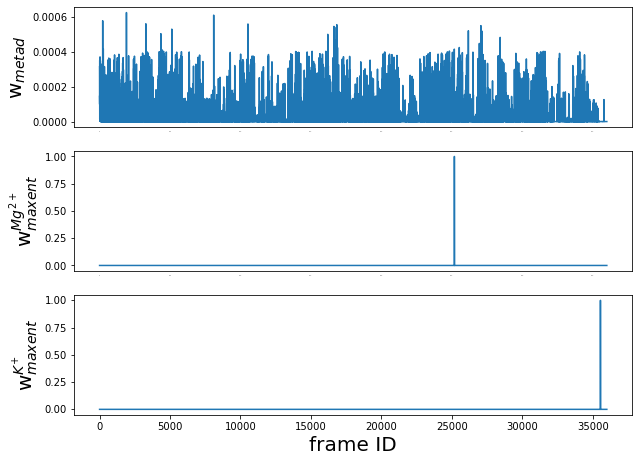

In [526]:
plt.figure(figsize=(10, 7.5))
plt.subplot(311)
plt.plot(weights)
plt.ylabel('w$_{metad}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)

plt.subplot(312)
plt.plot(dict_maxent['MG','crysol_4p','metad','singles','weights_me'])
plt.ylabel('w$_{maxent}^{Mg^{2+}}$',fontsize=20)
plt.tick_params(axis='x', labelsize=0, length = 0)

plt.subplot(313)
plt.plot(dict_maxent['K','crysol_4p','metad','singles','weights_me'])
plt.ylabel('w$_{maxent}^{K^{+}}$',fontsize=20)
plt.xlabel('frame ID',fontsize=20)

plt.show()
#plt.savefig('SI_FIG_weights_hummer_spectra_redone.png', format='png', dpi=300, bbox_inches='tight')

### Guinier fit on the reweighted spectra

In [527]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(observables_crys,axis=0,
        weights=dict_maxent['MG','crysol_4p','metad','singles','weights_me'])[2:7]))

In [528]:
fitted_line = linefitline(q[2:7]**2)

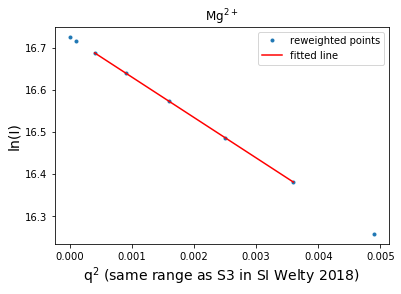

In [529]:
plt.plot(q[:8]**2,np.log(np.average(observables_crys,axis=0,
        weights=dict_maxent['MG','crysol_4p','metad','singles','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('Mg$^{2+}$')
plt.legend()
plt.show()

In [530]:
print('Guinier fit Rg* (exp. is 21.35):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 21.35):


16.946759383976897

In [531]:
print('weighted Rgcoord:')
np.average(metadb[1]*10,weights=dict_maxent['MG','crysol_4p','metad','singles','weights_me'])

weighted Rgcoord:


16.33954

In [532]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(np.average(observables_crys,axis=0,
        weights=dict_maxent['K','crysol_4p','metad','singles','weights_me'])[2:7]))

In [533]:
fitted_line = linefitline(q[2:7]**2)

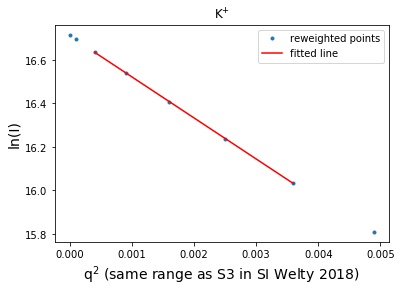

In [534]:
plt.plot(q[:8]**2,np.log(np.average(observables_crys,axis=0,
        weights=dict_maxent['K','crysol_4p','metad','singles','weights_me'])[:8]),
         '.',label='reweighted points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

plt.title('K$^{+}$')
plt.legend()
plt.show()

In [535]:
print('Guinier fit Rg* (exp. is 25.17):')
np.sqrt(-3*slope)

Guinier fit Rg* (exp. is 25.17):


23.78143025415021

In [536]:
print('weighted Rgcoord:')
np.average(metadb[1]*10,weights=dict_maxent['K','crysol_4p','metad','singles','weights_me'])

weighted Rgcoord:


23.86433

## Capriqorn parameters scan

Here we show the Rg* (computed through Guinier fit, as usual) resulting from a scan of the radius and shell width parameters of Capriqorn:

In [45]:
metad_rg_rmsd=np.loadtxt('./colvar_rg_rmsd')
metad_rg_rmsd.shape

(36001, 3)

In [46]:
where_list=[np.where((metad_rg_rmsd[:,1]<1.65)&(metad_rg_rmsd[:,2]<0.25))[0],
           np.where((metad_rg_rmsd[:,1]>1.65) & (metad_rg_rmsd[:,1]<1.70))[0],
           np.where((metad_rg_rmsd[:,1]>1.70) & (metad_rg_rmsd[:,1]<1.75))[0],
           np.where((metad_rg_rmsd[:,1]>1.75) & (metad_rg_rmsd[:,1]<1.80))[0],
           np.where((metad_rg_rmsd[:,1]>1.80) & (metad_rg_rmsd[:,1]<1.85))[0],
           np.where((metad_rg_rmsd[:,1]>1.85) & (metad_rg_rmsd[:,1]<1.90))[0],
           np.where((metad_rg_rmsd[:,1]>1.90) & (metad_rg_rmsd[:,1]<1.95))[0],
           np.where((metad_rg_rmsd[:,1]>1.95) & (metad_rg_rmsd[:,1]<2.00))[0],
           np.where((metad_rg_rmsd[:,1]>2.00) & (metad_rg_rmsd[:,1]<2.10))[0],
           np.where((metad_rg_rmsd[:,1]>2.10) & (metad_rg_rmsd[:,1]<2.20))[0],
           np.where((metad_rg_rmsd[:,1]>2.20) & (metad_rg_rmsd[:,1]<2.30))[0],
           np.where((metad_rg_rmsd[:,1]>2.30))[0]]

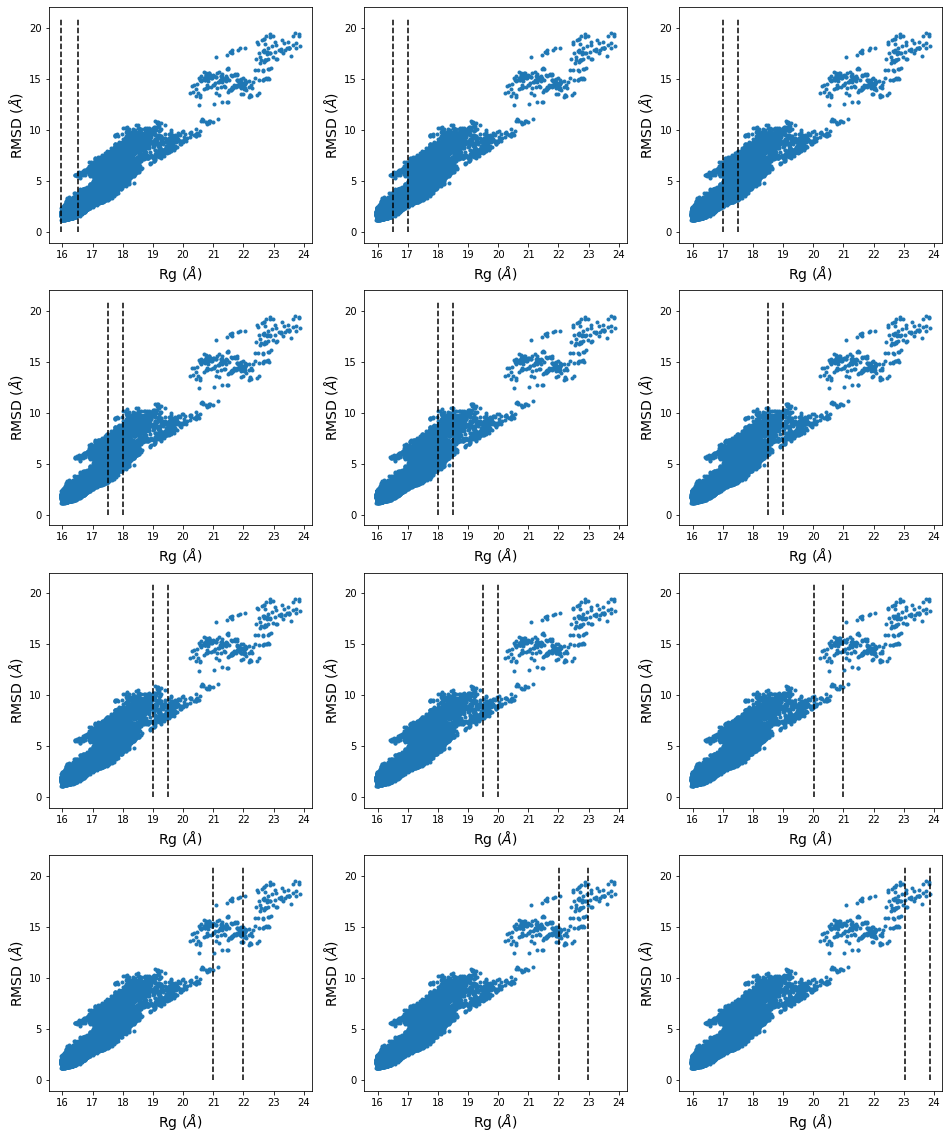

In [49]:
fig, axs = plt.subplots(4,3, figsize=(16,14))
axs = axs.ravel()


for i in range(len(where_list)):
    axs[i].plot(metad_rg_rmsd[:,1]*10,metad_rg_rmsd[:,2]*10,'.')
    axs[i].set_xlabel('Rg ($\AA$)',fontsize=14)
    axs[i].set_ylabel('RMSD ($\AA$)',fontsize=14)
    axs[i].set_xticks(np.linspace(16,24,9))
    axs[i].vlines(np.min(metad_rg_rmsd[where_list[i],1])*10,0,21,ls='--',zorder=10,color='black')
    axs[i].vlines(np.max(metad_rg_rmsd[where_list[i],1])*10,0,21,ls='--',zorder=10,color='black')
    
plt.subplots_adjust(top=1.2)
plt.show()
#plt.savefig('paper_FIGSI_Rg_RMSD_ranges.png', format='png', dpi=300, bbox_inches='tight')

In [42]:
colv_avg_scan=pickle.load(open("./colv_avg_scan.dat", "rb"))

In [43]:
avg_scan=pickle.load(open("./avg_scan.dat", "rb"))

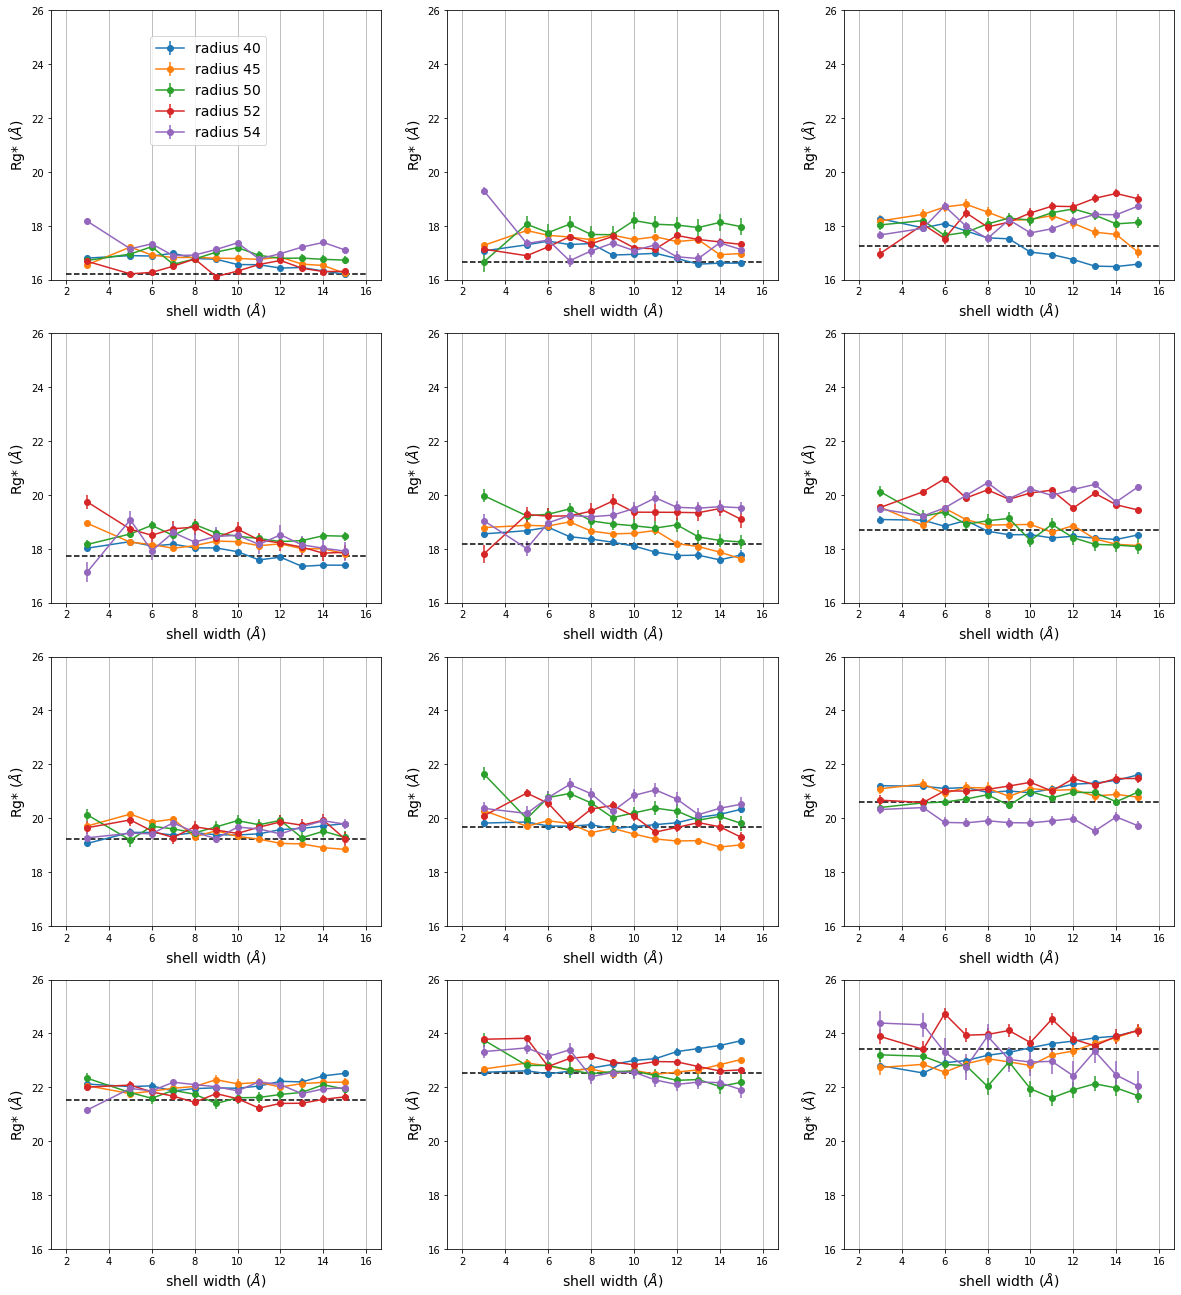

In [44]:
where_names=['metad_c','metad_ee165_170','metad_ee170_175','metad_ee175_180','metad_ee180_185','metad_ee185_190',
             'metad_ee190_195','metad_ee195_20',
             'metad_ee20_21','metad_ee21_22','metad_ee22_23','metad_ee']
colv_list_names=['colv_avg_scan_metad_c','colv_avg_scan_metad_ee165_170','colv_avg_scan_metad_ee170_175',
           'colv_avg_scan_metad_ee175_180','colv_avg_scan_metad_ee180_185','colv_avg_scan_metad_ee185_190',
          'colv_avg_scan_metad_ee190_195','colv_avg_scan_metad_ee195_20','colv_avg_scan_metad_ee20_21',
          'colv_avg_scan_metad_ee21_22','colv_avg_scan_metad_ee22_23','colv_avg_scan_metad_ee']

fig, axs = plt.subplots(4,3, figsize=(16,16))
axs = axs.ravel()

# for each radius there are 12 shell values (bs=12)
for i in range(len(where_names)):
    bs=12
    nb=int(len(avg_scan[where_names[i],'avg','Rg'])/bs)
    for j in range(nb):
        axs[i].errorbar(np.array(avg_scan[where_names[i],'sw'])*10,
                     avg_scan[where_names[i],'avg','Rg'][j*bs:(j+1)*bs],
                     yerr=avg_scan[where_names[i],'singles','err_Rg'][j*bs:(j+1)*bs],
                     fmt='o-',label='radius {}'.format(int(avg_scan[where_names[i],'R'][j]*10))) # ecolor='lightgray', elinewidth=3, capsize=0)

    axs[i].hlines(np.average(colv_avg_scan[colv_list_names[i]][:,1])*10,2,16,color='black',ls='--')

    axs[i].set_xlabel('shell width ($\AA$)',fontsize=14)
    axs[i].set_ylabel('Rg* ($\AA$)',fontsize=14)
    axs[i].set_ylim(16,26)
    axs[i].grid(axis='x')
    if i==0:
        axs[i].legend(fontsize=14,loc=(0.3,0.5))
plt.subplots_adjust(right=1.1,top=1.2)
plt.show()
#plt.savefig('paper_FIGSI_Rg_RMSD_plot_overview_new.png', format='png', dpi=300, bbox_inches='tight')

## Centroids from QT clustering

Reweighting the FES along Rg from the coordinates and ratio (peak/shoulder) computed with PLUMED:

In [30]:
new_histo_RgD=np.histogram2d(metadb[1],metadb[2],bins=(279,180),
               range=((np.min(metadb[1]),np.max(metadb[1])),
                      (np.min(metadb[2]),np.max(metadb[2]))),weights=weights)

In [31]:
new_fe_RgD=-2.5*np.log(new_histo_RgD[0])/4.184

<ipython-input-31-96eb2426ff1a>:1: RuntimeWarning: divide by zero encountered in log
  new_fe_RgD=-2.5*np.log(new_histo_RgD[0])/4.184


In [32]:
new_fe_RgD[np.isinf(new_fe_RgD)]=np.nan

In [33]:
X_RgD=np.zeros((180,279))
X_RgD[:]=((new_histo_RgD[1][1:]+new_histo_RgD[1][:-1])/2)
X_RgD=X_RgD.T
X_RgD.shape

(279, 180)

In [34]:
Y=np.zeros((279,180))
Y[:]=((new_histo_RgD[2][1:]+new_histo_RgD[2][:-1])/2)
Y.shape

(279, 180)

In [15]:
from mpl_toolkits import mplot3d
from matplotlib import cm

Indices of the cluster centroids, as identified through QT clustering on binnings of the Rg_coord vs ratio space:

In [19]:
all_centroids=np.array([ 9606, 13690, 13753, 15751, 18159, 20652, 21328, 21697, 22552,
       25117, 25672, 28728, 28762, 28950, 29111, 31432, 32376, 32608,
       32688, 32743, 33322, 34984, 35242, 35551, 35620, 35682, 35739])

In [36]:
labels=np.arange(1,len(all_centroids)+1,1)
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

Labels of the clustering (used in the figure here below) correspond to the indices in the "all_centroids.xtc" trajectory. To open it in VMD, run:  
vmd first_centroid_to_open_xtc.gro all_centroids.xtc

<ipython-input-37-b3ce150450e8>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  surf = ax.pcolormesh(X_RgD, Y, new_fe_RgD, cmap=cm.coolwarm) # , vmin=0, vmax=25


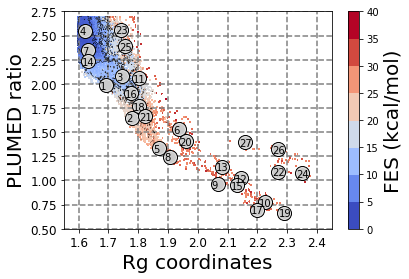

In [37]:
# to_copy

fig = plt.figure()

### ---

n=len(all_centroids)
#n=10
color=plt.cm.RdBu(np.linspace(0,1,n))[::-1] # [::-1] inverts from Blue to Red
# other available color maps: jet, rainbow

ax = plt.axes()
levels = np.arange(0, 40, 2)

surf = ax.pcolormesh(X_RgD, Y, new_fe_RgD, cmap=cm.coolwarm) # , vmin=0, vmax=25

CS = ax.contour(X_RgD, Y, new_fe_RgD, colors='black', linewidths=0.5)

plt.grid(axis='both', color='gray', linestyle='--', linewidth=1.5)

plt.colorbar(surf, boundaries=np.linspace(0,40,9)).ax.set_ylabel('FES (kcal/mol)', fontsize=20)

plt.xlabel("Rg coordinates", fontsize=20) # FreeSans is Linux closest to Helvetica
plt.ylabel("PLUMED ratio", fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(np.linspace(1.6,2.4,9),fontsize=12)
plt.xlim(1.55,2.45)
plt.ylim(0.5,2.75)

for i in range(len(all_centroids)):
#for i in range(len(centroids)):
    plt.plot(metadb[1][np.sort(all_centroids)[i]],metadb[2][np.sort(all_centroids)[i]],'o',
             markersize=14,color='black') # just adds the black outer line
    plt.plot(metadb[1][np.sort(all_centroids)[i]],metadb[2][np.sort(all_centroids)[i]],'o',
             markersize=12,c='white',alpha=0.8,label=i)
    plt.annotate(labels[i],(metadb[1][np.sort(all_centroids)[i]]-0.02,metadb[2][np.sort(all_centroids)[i]]-0.04),
                fontsize=10)

#plt.legend(loc=(1.3,0.1))

plt.show()

### ---

## Adding an offset to the experimental SAXS spectra

In [10]:
dict_maxent_scan={}

#
names=['metad','MG','K']
range_scan=np.arange(-0.01,0.01,0.0005)
range_scan[20]=0
#range_scan=np.arange(-0.01,-0.005,0.001)
for j in range(len(range_scan)):
    e_series=np.array([[np.average(observables_Hum,axis=0,weights=weights)[3],
                        np.average(observables_Hum,axis=0,weights=weights)[5],
                        np.average(observables_Hum,axis=0,weights=weights)[10],
                        np.average(observables_Hum,axis=0,weights=weights)[20]],
                       [y_mg[9]+range_scan[j],y_mg[29]+range_scan[j],
                        np.average(y_mg[69:90])+range_scan[j],np.average(y_mg[169:190])+range_scan[j]],
                       [y_k[9]+range_scan[j],y_k[29]+range_scan[j],
                        np.average(y_k[69:90])+range_scan[j],np.average(y_k[169:190])+range_scan[j]]])
    factor=1/1000 # div observables for a big number for numeric reas (we care about ratios, not a problem doing so)
    for i in range(len(names)):
        res_prop_i = minimize(Gamma_prop, np.array((0.0,0.0,0.0,0.0)), method='BFGS',tol=1e-10,jac=True,
                   args=(metadb[-1],factor*observables_Hum[:,[3,5,10,20]],e_series[i],1e-10))
        w_prop_i = weights_prop(res_prop_i.x,metadb[-1],factor*observables_Hum[:,[3,5,10,20]],e_series[i])
        kish_i = 1 / np.sum(w_prop_i**2)
        ###
        #dict_maxent[names[i],'hummer_4p','metad','singles','e_ratios']=e_series[i,2]/e_series[i,3]
        dict_maxent_scan['%.4f'%range_scan[j],names[i],'kish_sizes']=kish_i
        dict_maxent_scan['%.4f'%range_scan[j],names[i],'weights_me']=w_prop_i
        dict_maxent_scan['%.4f'%range_scan[j],names[i],'lagr_mult']=res_prop_i.x   

/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/

/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/

/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/

/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/Users/mbernett/my_progs/miniconda3/lib/python3.8/

In [11]:
exp_data={}
for j in range(len(range_scan)):
    ## MG
    # Rg*
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        gac_mg[:41,0]**2,
        np.log((gac_mg[:41,1]+range_scan[j])/(gac_mg[0,1]+range_scan[j])))
    #print('Mg: %.4f'%range_scan[j],np.sqrt(-3*slope))
    exp_data['%.4f'%range_scan[j],'MG','Rg*']=np.sqrt(-3*slope)
    # ratio
    ratio=((np.average(y_mg[69:90])+range_scan[j])*x_mg[79]**2)/((np.average(y_mg[169:190])+range_scan[j])*x_mg[179]**2)
    exp_data['%.4f'%range_scan[j],'MG','ratio']=ratio
    ## K
    # Rg*
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        gac_k[:41,0]**2,
        np.log((gac_k[:41,1]+range_scan[j])/(gac_k[0,1]+range_scan[j])))
    #print('K: %.4f'%range_scan[j],np.sqrt(-3*slope))
    exp_data['%.4f'%range_scan[j],'K','Rg*']=np.sqrt(-3*slope)
    # ratio
    ratio=((np.average(y_k[69:90])+range_scan[j])*x_k[79]**2)/((np.average(y_k[169:190])+range_scan[j])*x_k[179]**2)
    exp_data['%.4f'%range_scan[j],'K','ratio']=ratio
    #print()

In [12]:
comp_data={}
for j in range(len(range_scan)):
    for i in range(len(names)):
        ## MG
        # Rg*
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            q[2:7]**2,
            np.log(np.average(observables_Hum,axis=0,
                weights=dict_maxent_scan['%.4f'%range_scan[j],names[i],'weights_me'])[2:7]))
        comp_data['%.4f'%range_scan[j],names[i],'Rg*']=np.sqrt(-3*slope)
        # ratio
        ratio=(np.average(observables_Hum,axis=0,weights=dict_maxent_scan['%.4f'%range_scan[j],names[i],'weights_me'])*q**2)[10]/\
        (np.average(observables_Hum,axis=0,weights=dict_maxent_scan['%.4f'%range_scan[j],names[i],'weights_me'])*q**2)[20]
        comp_data['%.4f'%range_scan[j],names[i],'ratio']=ratio

In [13]:
names_c=['MG','K'] # check
scan_exp_ratio={}
scan_comp_ratio={}
scan_exp_Rgs={}
scan_comp_Rgs={}
for i in range(len(names_c)):
    scan_exp_ratio_i=[]
    scan_comp_ratio_i=[]
    scan_exp_Rgs_i=[]
    scan_comp_Rgs_i=[]
    for j in range(len(range_scan)):
        scan_exp_ratio_i.append(exp_data['%.4f'%range_scan[j],names_c[i],'ratio'])
        scan_comp_ratio_i.append(comp_data['%.4f'%range_scan[j],names_c[i],'ratio'])
        scan_exp_Rgs_i.append(exp_data['%.4f'%range_scan[j],names_c[i],'Rg*'])
        scan_comp_Rgs_i.append(comp_data['%.4f'%range_scan[j],names_c[i],'Rg*'])
    scan_exp_ratio[names_c[i]]=np.array(scan_exp_ratio_i)
    scan_comp_ratio[names_c[i]]=np.array(scan_comp_ratio_i)
    scan_exp_Rgs[names_c[i]]=np.array(scan_exp_Rgs_i)
    scan_comp_Rgs[names_c[i]]=np.array(scan_comp_Rgs_i)
#         print(names_c[i],'%.4f'%range_scan[j],
#               '%.4f'%exp_data['%.4f'%range_scan[j],names_c[i],'ratio'],
#               '%.4f'%comp_data['%.4f'%range_scan[j],names_c[i],'ratio'],
#               '%.4f'%exp_data['%.4f'%range_scan[j],names_c[i],'Rg*'],
#               '%.4f'%comp_data['%.4f'%range_scan[j],names_c[i],'Rg*'])
    #print()
        

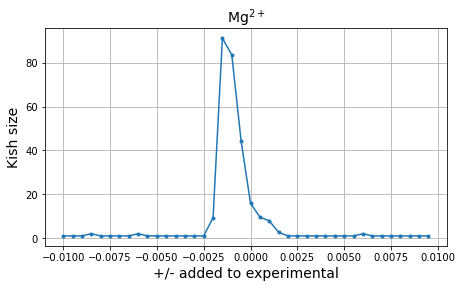

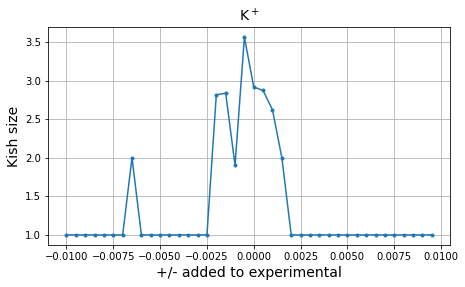

In [26]:
plt.figure(figsize=(7.2,4))
scan=[]
for j in range(len(range_scan)):
    scan.append(dict_maxent_scan['%.4f'%range_scan[j],'MG','kish_sizes'])

plt.plot(range_scan,scan,marker='.',label='Mg$^{2+}$')
plt.ylabel('Kish size',fontsize=14)
plt.xlabel('+/- added to experimental',fontsize=14)
plt.grid()
plt.title('Mg$^{2+}$',fontsize=14)
#plt.legend(fontsize=14)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.show()
plt.savefig('FIGSI_scan_offset1a.png', format='png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(7.2,4))
scan=[]
for j in range(len(range_scan)):
    scan.append(dict_maxent_scan['%.4f'%range_scan[j],'K','kish_sizes'])

plt.plot(range_scan,scan,marker='.',label='K$^{+}$')
plt.ylabel('Kish size',fontsize=14)
plt.xlabel('+/- added to experimental',fontsize=14)
plt.grid()
plt.title('K$^+$',fontsize=14)
#plt.legend(fontsize=14)
plt.show()
#plt.savefig('FIGSI_scan_offset1b.png', format='png', dpi=300, bbox_inches='tight')

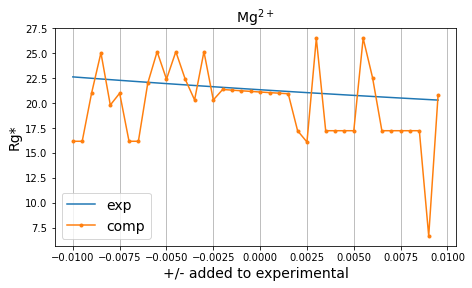

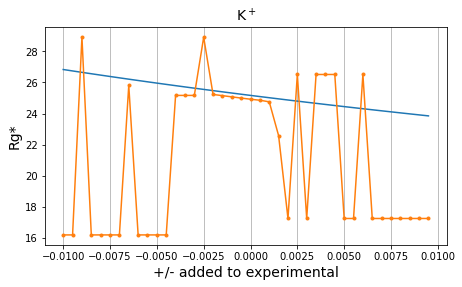

In [14]:
plt.figure(figsize=(7.2,4))
plt.plot(range_scan,scan_exp_Rgs['MG'],label='exp')
plt.plot(range_scan,scan_comp_Rgs['MG'],label='comp',marker='.')
#plt.xlim(-0.005,0.01)
#plt.ylim(0,10.5)
plt.ylabel('Rg*',fontsize=14)
plt.xlabel('+/- added to experimental',fontsize=14)
plt.title('Mg$^{2+}$',fontsize=14)
plt.grid(axis='x')
plt.legend(fontsize=14)
#plt.show()
plt.savefig('FIGSI_scan_offset3a.png', format='png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(7.2,4))
plt.plot(range_scan,scan_exp_Rgs['K'],label='exp')
plt.plot(range_scan,scan_comp_Rgs['K'],label='comp',marker='.')
#plt.xlim(-0.005,0.01)
#plt.ylim(0,10.5)
plt.ylabel('Rg*',fontsize=14)
plt.xlabel('+/- added to experimental',fontsize=14)
plt.title('K$^+$',fontsize=14)
plt.grid(axis='x')
#plt.legend(fontsize=14)
plt.show()
#plt.savefig('FIGSI_scan_offset3b.png', format='png', dpi=300, bbox_inches='tight')

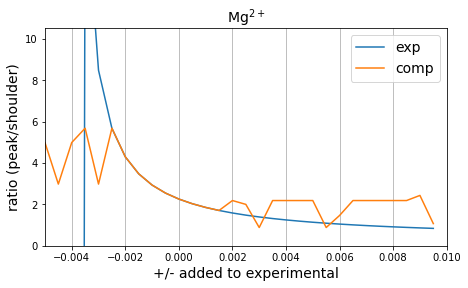

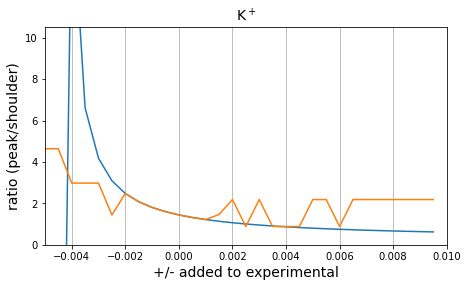

In [15]:
plt.figure(figsize=(7.2,4))
plt.plot(range_scan,scan_exp_ratio['MG'],label='exp')
plt.plot(range_scan,scan_comp_ratio['MG'],label='comp')
plt.xlim(-0.005,0.01)
plt.ylim(0,10.5)
plt.ylabel('ratio (peak/shoulder)',fontsize=14)
plt.xlabel('+/- added to experimental',fontsize=14)
plt.title('Mg$^{2+}$',fontsize=14)
plt.grid(axis='x')
plt.legend(fontsize=14)
plt.show()
#plt.savefig('FIGSI_scan_offset2a.png', format='png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(7.2,4))
plt.plot(range_scan,scan_exp_ratio['K'],label='exp')
plt.plot(range_scan,scan_comp_ratio['K'],label='comp')
plt.xlim(-0.005,0.01)
plt.ylim(0,10.5)
plt.ylabel('ratio (peak/shoulder)',fontsize=14)
plt.xlabel('+/- added to experimental',fontsize=14)
plt.title('K$^+$',fontsize=14)
plt.grid(axis='x')
#plt.legend(fontsize=14)
plt.show()
#plt.savefig('FIGSI_scan_offset2b.png', format='png', dpi=300, bbox_inches='tight')